In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
1_5_6


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5074 - accuracy: 0.7646 - precision: 0.9559 - recall: 0.7730 - f1: 0.8444 - specificity: 0.6962 - negative_predictive_value: 0.2873 - matthews_correlation_coefficient: 0.3336 - val_loss: 0.4996 - val_accuracy: 0.7251 - val_precision: 0.9655 - val_recall: 0.7297 - val_f1: 0.8266 - val_specificity: 0.6707 - val_negative_predictive_value: 0.2365 - val_matthews_correlation_coefficient: 0.2859

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28586, saving model to ../models/autoencoders_requirements/blurred_2020_03_24-22_09_13.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4442 - accuracy: 0.7722 - precision: 0.9703 - recall: 0.7746 - f1: 0.8559 - specificity: 0.7554 - negative_predictive_value: 0.2896 - matthews_correlation_coefficient: 0.3643 - val_loss: 0.4260 - val_accuracy: 0.8248 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3773 - accuracy: 0.8113 - precision: 0.9794 - recall: 0.8084 - f1: 0.8826 - specificity: 0.7907 - negative_predictive_value: 0.3304 - matthews_correlation_coefficient: 0.4241 - val_loss: 0.4750 - val_accuracy: 0.7832 - val_precision: 0.9728 - val_recall: 0.7874 - val_f1: 0.8682 - val_specificity: 0.7126 - val_negative_predictive_value: 0.2831 - val_matthews_correlation_coefficient: 0.3603

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39625
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3698 - accuracy: 0.8169 - precision: 0.9814 - recall: 0.8146 - f1: 0.8870 - specificity: 0.8000 - negative_predictive_value: 0.3347 - matthews_correlation_coefficient: 0.4316 - val_loss: 0.4367 - val_accuracy: 0.7971 - val_precision: 0.9705 - val_recall: 0.8057 - val_f1: 0.8785 - val_specificity: 0.6878 - val_negative_predictive_value: 0.2924 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42804
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3438 - accuracy: 0.8330 - precision: 0.9794 - recall: 0.8319 - f1: 0.8960 - specificity: 0.8056 - negative_predictive_value: 0.3604 - matthews_correlation_coefficient: 0.4585 - val_loss: 0.3762 - val_accuracy: 0.8196 - val_precision: 0.9715 - val_recall: 0.8303 - val_f1: 0.8933 - val_specificity: 0.6914 - val_negative_predictive_value: 0.3227 - val_matthews_correlation_coefficient: 0.3915

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.42804
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3761 - accuracy: 0.8286 - precision: 0.9793 - recall: 0.8294 - f1: 0.8925 - specificity: 0.7797 - negative_predictive_value: 0.3712 - matthews_correlation_coefficient: 0.4538 - val_loss: 0.4354 - val_accuracy: 0.8170 - val_precision: 0.9780 - val_recall: 0.8217 - val_f1: 0.8912 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.42841 to 0.45657, saving model to ../models/autoencoders_requirements/blurred_2020_03_24-22_09_13.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3210 - accuracy: 0.8544 - precision: 0.9831 - recall: 0.8546 - f1: 0.9130 - specificity: 0.8038 - negative_predictive_value: 0.3811 - matthews_correlation_coefficient: 0.4835 - val_loss: 0.3329 - val_accuracy: 0.8604 - val_precision: 0.9751 - val_recall: 0.8717 - val_f1: 0.9192 - val_specificity: 0.7045 - val_negative_predictive_value: 0.3775 - val_matthews_correlation_coefficient: 0.4487

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.45657
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3219 - accuracy: 0.8623 - precision: 0.9827 - recall: 0.8645 - f1: 0.9178 - specificity: 0.7972 - negative_predictive_value: 0.4125 - matthews_correlation_coefficient: 0.5040 - val_loss: 0.4179 - val_


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45657
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3061 - accuracy: 0.8549 - precision: 0.9847 - recall: 0.8533 - f1: 0.9123 - specificity: 0.8302 - negative_predictive_value: 0.3939 - matthews_correlation_coefficient: 0.5001 - val_loss: 0.2772 - val_accuracy: 0.8838 - val_precision: 0.9727 - val_recall: 0.8995 - val_f1: 0.9338 - val_specificity: 0.6847 - val_negative_predictive_value: 0.4190 - val_matthews_correlation_coefficient: 0.4739

Epoch 00060: val_matthews_correlation_coefficient improved from 0.45657 to 0.47395, saving model to ../models/autoencoders_requirements/blurred_2020_03_24-22_09_13.h5
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3079 - accuracy: 0.8540 - precision: 0.9851 - recall: 0.8526 - f1: 0.9124 - specificity: 0.8675 - negative_predictive_value: 0.4028 - matthews_correlation_coefficient: 0.5180 - val_loss: 0.3482 - val_


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.47395
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2951 - accuracy: 0.8590 - precision: 0.9872 - recall: 0.8562 - f1: 0.9150 - specificity: 0.8563 - negative_predictive_value: 0.4062 - matthews_correlation_coefficient: 0.5212 - val_loss: 0.2719 - val_accuracy: 0.8855 - val_precision: 0.9690 - val_recall: 0.9051 - val_f1: 0.9351 - val_specificity: 0.6405 - val_negative_predictive_value: 0.4180 - val_matthews_correlation_coefficient: 0.4555

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.47395
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2944 - accuracy: 0.8638 - precision: 0.9871 - recall: 0.8618 - f1: 0.9181 - specificity: 0.8620 - negative_predictive_value: 0.4218 - matthews_correlation_coefficient: 0.5334 - val_loss: 0.3413 - val_accuracy: 0.8638 - val_precision: 0.9767 - val_recall: 0.8738 - val_f1: 0.9213 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2728 - accuracy: 0.8692 - precision: 0.9873 - recall: 0.8672 - f1: 0.9217 - specificity: 0.8590 - negative_predictive_value: 0.4231 - matthews_correlation_coefficient: 0.5352 - val_loss: 0.3392 - val_accuracy: 0.8552 - val_precision: 0.9807 - val_recall: 0.8608 - val_f1: 0.9156 - val_specificity: 0.7410 - val_negative_predictive_value: 0.3776 - val_matthews_correlation_coefficient: 0.4635

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.47948
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2763 - accuracy: 0.8633 - precision: 0.9880 - recall: 0.8605 - f1: 0.9180 - specificity: 0.8707 - negative_predictive_value: 0.4195 - matthews_correlation_coefficient: 0.5342 - val_loss: 0.3040 - val_accuracy: 0.8812 - val_precision: 0.9718 - val_recall: 0.8981 - val_f1: 0.9326 - val_specificity: 0.6658 - val_negative_predictive_value: 0.4149 - val_matthews_correlation_coefficie

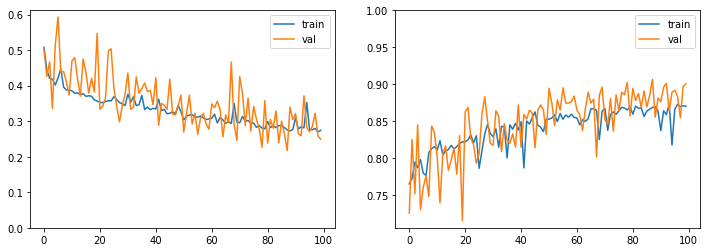

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6769 - accuracy: 0.5980 - precision: 0.7382 - recall: 0.6216 - f1: 0.6600 - specificity: 0.5486 - negative_predictive_value: 0.4261 - matthews_correlation_coefficient: 0.1724 - val_loss: 0.6505 - val_accuracy: 0.6531 - val_precision: 0.7522 - val_recall: 0.7339 - val_f1: 0.7386 - val_specificity: 0.4914 - val_negative_predictive_value: 0.4705 - val_matthews_correlation_coefficient: 0.2229

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22292, saving model to ../models/autoencoders_requirements/looking_away_2020_03_24-22_24_05.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6660 - accuracy: 0.6156 - precision: 0.7554 - recall: 0.6364 - f1: 0.6770 - specificity: 0.5784 - negative_predictive_value: 0.4541 - matthews_correlation_coefficient: 0.2130 - val_loss: 0.7035 - val_accuracy: 0.5603 - val_precision


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.29289
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6360 - accuracy: 0.6523 - precision: 0.7846 - recall: 0.6677 - f1: 0.7119 - specificity: 0.6230 - negative_predictive_value: 0.4905 - matthews_correlation_coefficient: 0.2833 - val_loss: 0.6152 - val_accuracy: 0.6696 - val_precision: 0.8012 - val_recall: 0.6857 - val_f1: 0.7343 - val_specificity: 0.6325 - val_negative_predictive_value: 0.4885 - val_matthews_correlation_coefficient: 0.3029

Epoch 00015: val_matthews_correlation_coefficient improved from 0.29289 to 0.30289, saving model to ../models/autoencoders_requirements/looking_away_2020_03_24-22_24_05.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6280 - accuracy: 0.6607 - precision: 0.7911 - recall: 0.6758 - f1: 0.7199 - specificity: 0.6411 - negative_predictive_value: 0.5027 - matthews_correlation_coefficient: 0.3041 - val_loss: 0.6072 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5872 - accuracy: 0.6922 - precision: 0.8059 - recall: 0.7147 - f1: 0.7507 - specificity: 0.6491 - negative_predictive_value: 0.5376 - matthews_correlation_coefficient: 0.3542 - val_loss: 0.5587 - val_accuracy: 0.7121 - val_precision: 0.7673 - val_recall: 0.8280 - val_f1: 0.7941 - val_specificity: 0.4686 - val_negative_predictive_value: 0.5550 - val_matthews_correlation_coefficient: 0.3084

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.34972
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5955 - accuracy: 0.6872 - precision: 0.8015 - recall: 0.7107 - f1: 0.7454 - specificity: 0.6445 - negative_predictive_value: 0.5352 - matthews_correlation_coefficient: 0.3463 - val_loss: 0.6258 - val_accuracy: 0.6618 - val_precision: 0.7462 - val_recall: 0.7624 - val_f1: 0.7506 - val_specificity: 0.4574 - val_negative_predictive_value: 0.4829 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.36316
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5775 - accuracy: 0.7017 - precision: 0.8153 - recall: 0.7178 - f1: 0.7562 - specificity: 0.6831 - negative_predictive_value: 0.5562 - matthews_correlation_coefficient: 0.3844 - val_loss: 0.5812 - val_accuracy: 0.6626 - val_precision: 0.8110 - val_recall: 0.6542 - val_f1: 0.7215 - val_specificity: 0.6687 - val_negative_predictive_value: 0.4787 - val_matthews_correlation_coefficient: 0.3052

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.36316
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5718 - accuracy: 0.7054 - precision: 0.8209 - recall: 0.7202 - f1: 0.7611 - specificity: 0.6857 - negative_predictive_value: 0.5536 - matthews_correlation_coefficient: 0.3887 - val_loss: 0.6088 - val_accuracy: 0.6687 - val_precision: 0.8218 - val_recall: 0.6555 - val_f1: 0.7244 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.36490
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5619 - accuracy: 0.7072 - precision: 0.8258 - recall: 0.7154 - f1: 0.7604 - specificity: 0.6900 - negative_predictive_value: 0.5510 - matthews_correlation_coefficient: 0.3900 - val_loss: 0.5966 - val_accuracy: 0.6938 - val_precision: 0.8360 - val_recall: 0.6918 - val_f1: 0.7527 - val_specificity: 0.6863 - val_negative_predictive_value: 0.5109 - val_matthews_correlation_coefficient: 0.3615

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.36490
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5568 - accuracy: 0.7176 - precision: 0.8280 - recall: 0.7344 - f1: 0.7719 - specificity: 0.6895 - negative_predictive_value: 0.5671 - matthews_correlation_coefficient: 0.4098 - val_loss: 0.5549 - val_accuracy: 0.6982 - val_precision: 0.8202 - val_recall: 0.7094 - val_f1: 0.7586 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.37263
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5492 - accuracy: 0.7134 - precision: 0.8384 - recall: 0.7121 - f1: 0.7636 - specificity: 0.7249 - negative_predictive_value: 0.5622 - matthews_correlation_coefficient: 0.4177 - val_loss: 0.5626 - val_accuracy: 0.6990 - val_precision: 0.8137 - val_recall: 0.7230 - val_f1: 0.7624 - val_specificity: 0.6416 - val_negative_predictive_value: 0.5231 - val_matthews_correlation_coefficient: 0.3498

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.37263
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5519 - accuracy: 0.7132 - precision: 0.8297 - recall: 0.7232 - f1: 0.7644 - specificity: 0.6946 - negative_predictive_value: 0.5616 - matthews_correlation_coefficient: 0.4050 - val_loss: 0.6191 - val_accuracy: 0.6331 - val_precision: 0.8444 - val_recall: 0.5650 - val_f1: 0.6697 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.38539
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5443 - accuracy: 0.7184 - precision: 0.8369 - recall: 0.7170 - f1: 0.7653 - specificity: 0.7156 - negative_predictive_value: 0.5600 - matthews_correlation_coefficient: 0.4144 - val_loss: 0.5939 - val_accuracy: 0.6817 - val_precision: 0.8124 - val_recall: 0.6925 - val_f1: 0.7435 - val_specificity: 0.6470 - val_negative_predictive_value: 0.5024 - val_matthews_correlation_coefficient: 0.3264

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.38539
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5403 - accuracy: 0.7191 - precision: 0.8429 - recall: 0.7185 - f1: 0.7683 - specificity: 0.7282 - negative_predictive_value: 0.5728 - matthews_correlation_coefficient: 0.4298 - val_loss: 0.5603 - val_accuracy: 0.6973 - val_precision: 0.8080 - val_recall: 0.7274 - val_f1: 0.7624 - val_spe

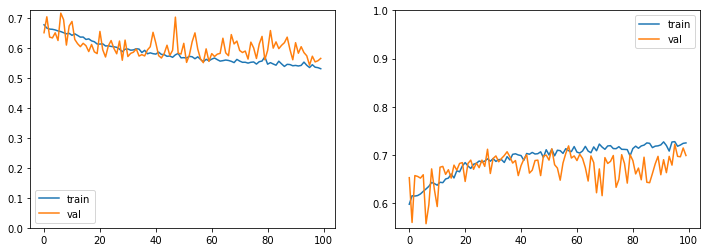

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6207 - accuracy: 0.6616 - precision: 0.6843 - recall: 0.6266 - f1: 0.6280 - specificity: 0.6992 - negative_predictive_value: 0.6605 - matthews_correlation_coefficient: 0.3427 - val_loss: 0.5941 - val_accuracy: 0.6748 - val_precision: 0.6802 - val_recall: 0.6678 - val_f1: 0.6685 - val_specificity: 0.6749 - val_negative_predictive_value: 0.6591 - val_matthews_correlation_coefficient: 0.3409

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34093, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_24-22_38_47.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5825 - accuracy: 0.7076 - precision: 0.7196 - recall: 0.7512 - f1: 0.7201 - specificity: 0.6676 - negative_predictive_value: 0.7137 - matthews_correlation_coefficient: 0.4324 - val_loss: 0.5693 - val_accuracy: 0.7381 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4699 - accuracy: 0.7659 - precision: 0.7648 - recall: 0.8187 - f1: 0.7805 - specificity: 0.7054 - negative_predictive_value: 0.7843 - matthews_correlation_coefficient: 0.5376 - val_loss: 0.5031 - val_accuracy: 0.7554 - val_precision: 0.6953 - val_recall: 0.8790 - val_f1: 0.7712 - val_specificity: 0.6090 - val_negative_predictive_value: 0.8537 - val_matthews_correlation_coefficient: 0.5168

Epoch 00015: val_matthews_correlation_coefficient improved from 0.51657 to 0.51677, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_24-22_38_47.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4615 - accuracy: 0.7785 - precision: 0.7688 - recall: 0.8435 - f1: 0.7983 - specificity: 0.7125 - negative_predictive_value: 0.8044 - matthews_correlation_coefficient: 0.5642 - val_loss: 0.4944 - val_accuracy: 0.7415 - val_precision: 0.7482 - val_recall: 0.7149 - val_f1: 0.7242 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4409 - accuracy: 0.7879 - precision: 0.7869 - recall: 0.8136 - f1: 0.7932 - specificity: 0.7535 - negative_predictive_value: 0.7904 - matthews_correlation_coefficient: 0.5737 - val_loss: 0.4726 - val_accuracy: 0.7684 - val_precision: 0.7411 - val_recall: 0.8028 - val_f1: 0.7644 - val_specificity: 0.7189 - val_negative_predictive_value: 0.7949 - val_matthews_correlation_coefficient: 0.5283

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.54731
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4296 - accuracy: 0.7978 - precision: 0.7945 - recall: 0.8366 - f1: 0.8087 - specificity: 0.7504 - negative_predictive_value: 0.8016 - matthews_correlation_coefficient: 0.5929 - val_loss: 0.4719 - val_accuracy: 0.7736 - val_precision: 0.7148 - val_recall: 0.8802 - val_f1: 0.7839 - val_specificity: 0.6430 - val_negative_predictive_value: 0.8599 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.54932
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4307 - accuracy: 0.7907 - precision: 0.7831 - recall: 0.8249 - f1: 0.7958 - specificity: 0.7541 - negative_predictive_value: 0.8010 - matthews_correlation_coefficient: 0.5828 - val_loss: 0.4728 - val_accuracy: 0.7762 - val_precision: 0.7284 - val_recall: 0.8494 - val_f1: 0.7787 - val_specificity: 0.6812 - val_negative_predictive_value: 0.8385 - val_matthews_correlation_coefficient: 0.5475

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.54932
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4276 - accuracy: 0.7941 - precision: 0.7931 - recall: 0.8410 - f1: 0.8072 - specificity: 0.7397 - negative_predictive_value: 0.8070 - matthews_correlation_coefficient: 0.5916 - val_loss: 0.4650 - val_accuracy: 0.7892 - val_precision: 0.7539 - val_recall: 0.8284 - val_f1: 0.7846 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4112 - accuracy: 0.8076 - precision: 0.7992 - recall: 0.8428 - f1: 0.8138 - specificity: 0.7668 - negative_predictive_value: 0.8208 - matthews_correlation_coefficient: 0.6161 - val_loss: 0.5070 - val_accuracy: 0.7589 - val_precision: 0.7629 - val_recall: 0.7303 - val_f1: 0.7413 - val_specificity: 0.7756 - val_negative_predictive_value: 0.7423 - val_matthews_correlation_coefficient: 0.5054

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.58379
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4135 - accuracy: 0.8035 - precision: 0.8007 - recall: 0.8332 - f1: 0.8094 - specificity: 0.7638 - negative_predictive_value: 0.8079 - matthews_correlation_coefficient: 0.6023 - val_loss: 0.4993 - val_accuracy: 0.7676 - val_precision: 0.7070 - val_recall: 0.8801 - val_f1: 0.7797 - val_specificity: 0.6299 - val_negative_predictive_value: 0.8573 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3985 - accuracy: 0.8161 - precision: 0.8186 - recall: 0.8456 - f1: 0.8260 - specificity: 0.7813 - negative_predictive_value: 0.8150 - matthews_correlation_coefficient: 0.6299 - val_loss: 0.4675 - val_accuracy: 0.7814 - val_precision: 0.7220 - val_recall: 0.8836 - val_f1: 0.7904 - val_specificity: 0.6538 - val_negative_predictive_value: 0.8655 - val_matthews_correlation_coefficient: 0.5608

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.58379
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3924 - accuracy: 0.8171 - precision: 0.8073 - recall: 0.8500 - f1: 0.8231 - specificity: 0.7700 - negative_predictive_value: 0.8239 - matthews_correlation_coefficient: 0.6253 - val_loss: 0.4633 - val_accuracy: 0.7780 - val_precision: 0.7917 - val_recall: 0.7314 - val_f1: 0.7553 - val_specificity: 0.8160 - val_negative_predictive_value: 0.7537 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.58972
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3914 - accuracy: 0.8171 - precision: 0.8124 - recall: 0.8373 - f1: 0.8187 - specificity: 0.7912 - negative_predictive_value: 0.8233 - matthews_correlation_coefficient: 0.6318 - val_loss: 0.4392 - val_accuracy: 0.7988 - val_precision: 0.7646 - val_recall: 0.8296 - val_f1: 0.7913 - val_specificity: 0.7490 - val_negative_predictive_value: 0.8279 - val_matthews_correlation_coefficient: 0.5851

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.58972
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3871 - accuracy: 0.8200 - precision: 0.8220 - recall: 0.8356 - f1: 0.8218 - specificity: 0.7905 - negative_predictive_value: 0.8140 - matthews_correlation_coefficient: 0.6375 - val_loss: 0.4782 - val_accuracy: 0.7762 - val_precision: 0.7629 - val_recall: 0.7806 - val_f1: 0.7647 - val_spe

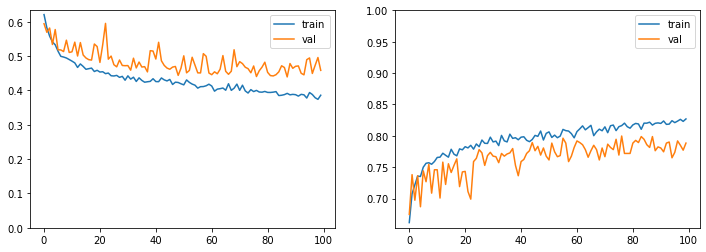

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6135 - accuracy: 0.6837 - precision: 0.9006 - recall: 0.6928 - f1: 0.7636 - specificity: 0.6143 - negative_predictive_value: 0.2587 - matthews_correlation_coefficient: 0.2358 - val_loss: 0.6831 - val_accuracy: 0.6141 - val_precision: 0.9340 - val_recall: 0.5637 - val_f1: 0.6985 - val_specificity: 0.8118 - val_negative_predictive_value: 0.2546 - val_matthews_correlation_coefficient: 0.2665

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.26652, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_24-22_53_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5335 - accuracy: 0.7265 - precision: 0.9568 - recall: 0.7205 - f1: 0.8150 - specificity: 0.7880 - negative_predictive_value: 0.3246 - matthews_correlation_coefficient: 0.3718 - val_loss: 0.7079 - val_accuracy: 0.6036 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4596 - accuracy: 0.7711 - precision: 0.9637 - recall: 0.7712 - f1: 0.8488 - specificity: 0.8113 - negative_predictive_value: 0.3838 - matthews_correlation_coefficient: 0.4384 - val_loss: 0.3912 - val_accuracy: 0.8135 - val_precision: 0.9127 - val_recall: 0.8186 - val_f1: 0.8616 - val_specificity: 0.5657 - val_negative_predictive_value: 0.3571 - val_matthews_correlation_coefficient: 0.3480

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.38934
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4313 - accuracy: 0.7892 - precision: 0.9657 - recall: 0.7884 - f1: 0.8644 - specificity: 0.8135 - negative_predictive_value: 0.3809 - matthews_correlation_coefficient: 0.4469 - val_loss: 0.6005 - val_accuracy: 0.6878 - val_precision: 0.9430 - val_recall: 0.6418 - val_f1: 0.7609 - val_specificity: 0.7967 - val_negative_predictive_value: 0.2701 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4032 - accuracy: 0.8050 - precision: 0.9683 - recall: 0.8006 - f1: 0.8724 - specificity: 0.8000 - negative_predictive_value: 0.4043 - matthews_correlation_coefficient: 0.4684 - val_loss: 0.6142 - val_accuracy: 0.6999 - val_precision: 0.9461 - val_recall: 0.6545 - val_f1: 0.7704 - val_specificity: 0.8021 - val_negative_predictive_value: 0.2772 - val_matthews_correlation_coefficient: 0.3466

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.38934
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3928 - accuracy: 0.8093 - precision: 0.9687 - recall: 0.8086 - f1: 0.8779 - specificity: 0.8090 - negative_predictive_value: 0.4039 - matthews_correlation_coefficient: 0.4718 - val_loss: 0.4561 - val_accuracy: 0.7797 - val_precision: 0.9277 - val_recall: 0.7630 - val_f1: 0.8355 - val_specificity: 0.6786 - val_negative_predictive_value: 0.3314 - val_matthews_correlation_coefficie


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39949
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4241 - accuracy: 0.7831 - precision: 0.9734 - recall: 0.7707 - f1: 0.8498 - specificity: 0.8514 - negative_predictive_value: 0.4016 - matthews_correlation_coefficient: 0.4766 - val_loss: 0.4649 - val_accuracy: 0.7788 - val_precision: 0.9318 - val_recall: 0.7579 - val_f1: 0.8341 - val_specificity: 0.7245 - val_negative_predictive_value: 0.3357 - val_matthews_correlation_coefficient: 0.3846

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.39949
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3797 - accuracy: 0.8134 - precision: 0.9727 - recall: 0.8113 - f1: 0.8819 - specificity: 0.8376 - negative_predictive_value: 0.4124 - matthews_correlation_coefficient: 0.4922 - val_loss: 0.4462 - val_accuracy: 0.7962 - val_precision: 0.9374 - val_recall: 0.7733 - val_f1: 0.8457 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3722 - accuracy: 0.8260 - precision: 0.9716 - recall: 0.8254 - f1: 0.8905 - specificity: 0.8395 - negative_predictive_value: 0.4203 - matthews_correlation_coefficient: 0.5015 - val_loss: 0.5670 - val_accuracy: 0.7363 - val_precision: 0.9464 - val_recall: 0.6965 - val_f1: 0.7993 - val_specificity: 0.7967 - val_negative_predictive_value: 0.3065 - val_matthews_correlation_coefficient: 0.3810

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.43295
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3680 - accuracy: 0.8256 - precision: 0.9721 - recall: 0.8247 - f1: 0.8899 - specificity: 0.8192 - negative_predictive_value: 0.4254 - matthews_correlation_coefficient: 0.5008 - val_loss: 0.6392 - val_accuracy: 0.7181 - val_precision: 0.9471 - val_recall: 0.6757 - val_f1: 0.7856 - val_specificity: 0.8059 - val_negative_predictive_value: 0.2972 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3509 - accuracy: 0.8440 - precision: 0.9740 - recall: 0.8445 - f1: 0.9027 - specificity: 0.8501 - negative_predictive_value: 0.4657 - matthews_correlation_coefficient: 0.5449 - val_loss: 0.4918 - val_accuracy: 0.7832 - val_precision: 0.9416 - val_recall: 0.7552 - val_f1: 0.8364 - val_specificity: 0.7685 - val_negative_predictive_value: 0.3454 - val_matthews_correlation_coefficient: 0.4146

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.43295
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3532 - accuracy: 0.8375 - precision: 0.9750 - recall: 0.8360 - f1: 0.8978 - specificity: 0.8706 - negative_predictive_value: 0.4549 - matthews_correlation_coefficient: 0.5418 - val_loss: 0.4952 - val_accuracy: 0.7754 - val_precision: 0.9365 - val_recall: 0.7500 - val_f1: 0.8309 - val_specificity: 0.7451 - val_negative_predictive_value: 0.3339 - val_matthews_correlation_coefficie


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.46666
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3328 - accuracy: 0.8403 - precision: 0.9773 - recall: 0.8376 - f1: 0.9000 - specificity: 0.8711 - negative_predictive_value: 0.4549 - matthews_correlation_coefficient: 0.5442 - val_loss: 0.5153 - val_accuracy: 0.7676 - val_precision: 0.9484 - val_recall: 0.7320 - val_f1: 0.8239 - val_specificity: 0.8217 - val_negative_predictive_value: 0.3354 - val_matthews_correlation_coefficient: 0.4209

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.46666
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3444 - accuracy: 0.8447 - precision: 0.9743 - recall: 0.8449 - f1: 0.9031 - specificity: 0.8556 - negative_predictive_value: 0.4633 - matthews_correlation_coefficient: 0.5466 - val_loss: 0.4602 - val_accuracy: 0.7953 - val_precision: 0.9386 - val_recall: 0.7715 - val_f1: 0.8450 - val_spe

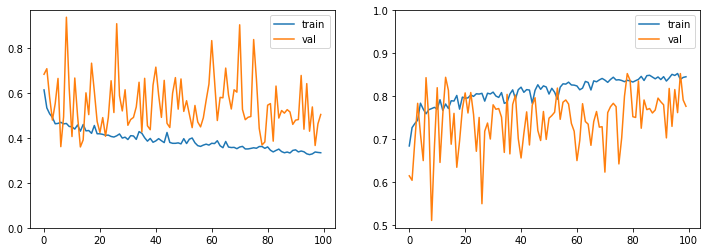

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6261 - accuracy: 0.7104 - precision: 0.9949 - recall: 0.7139 - f1: 0.8158 - specificity: 0.1701 - negative_predictive_value: 0.0205 - matthews_correlation_coefficient: 0.0404 - val_loss: 0.3884 - val_accuracy: 0.7199 - val_precision: 0.9707 - val_recall: 0.7000 - val_f1: 0.8102 - val_specificity: 0.2162 - val_negative_predictive_value: 0.0336 - val_matthews_correlation_coefficient: 0.0670

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06703, saving model to ../models/autoencoders_requirements/washed_out_2020_03_24-23_08_03.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5178 - accuracy: 0.7332 - precision: 0.9976 - recall: 0.7342 - f1: 0.8387 - specificity: 0.2115 - negative_predictive_value: 0.0331 - matthews_correlation_coefficient: 0.0637 - val_loss: 0.3943 - val_accuracy: 0.6964 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2757 - accuracy: 0.9043 - precision: 0.9988 - recall: 0.9049 - f1: 0.9470 - specificity: 0.2448 - negative_predictive_value: 0.0963 - matthews_correlation_coefficient: 0.1331 - val_loss: 0.2888 - val_accuracy: 0.8309 - val_precision: 0.9698 - val_recall: 0.8101 - val_f1: 0.8811 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0531 - val_matthews_correlation_coefficient: 0.0850

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.14443
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2479 - accuracy: 0.8980 - precision: 0.9984 - recall: 0.8991 - f1: 0.9429 - specificity: 0.2414 - negative_predictive_value: 0.1011 - matthews_correlation_coefficient: 0.1380 - val_loss: 0.1483 - val_accuracy: 0.9558 - val_precision: 0.9974 - val_recall: 0.9592 - val_f1: 0.9776 - val_specificity: 0.1892 - val_negative_predictive_value: 0.1396 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.16326
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1888 - accuracy: 0.9354 - precision: 0.9988 - recall: 0.9360 - f1: 0.9646 - specificity: 0.2552 - negative_predictive_value: 0.1379 - matthews_correlation_coefficient: 0.1712 - val_loss: 0.1109 - val_accuracy: 0.9705 - val_precision: 0.9974 - val_recall: 0.9736 - val_f1: 0.9851 - val_specificity: 0.1892 - val_negative_predictive_value: 0.1351 - val_matthews_correlation_coefficient: 0.1542

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.16326
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2551 - accuracy: 0.9243 - precision: 0.9984 - recall: 0.9254 - f1: 0.9583 - specificity: 0.2172 - negative_predictive_value: 0.1099 - matthews_correlation_coefficient: 0.1397 - val_loss: 0.1086 - val_accuracy: 0.9801 - val_precision: 0.9974 - val_recall: 0.9830 - val_f1: 0.9900 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.16364
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1956 - accuracy: 0.9536 - precision: 0.9989 - recall: 0.9545 - f1: 0.9757 - specificity: 0.2724 - negative_predictive_value: 0.1418 - matthews_correlation_coefficient: 0.1861 - val_loss: 0.2078 - val_accuracy: 0.9532 - val_precision: 0.9974 - val_recall: 0.9565 - val_f1: 0.9763 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0991 - val_matthews_correlation_coefficient: 0.1296

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.16364
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2090 - accuracy: 0.9566 - precision: 0.9986 - recall: 0.9578 - f1: 0.9773 - specificity: 0.2345 - negative_predictive_value: 0.1476 - matthews_correlation_coefficient: 0.1760 - val_loss: 0.1971 - val_accuracy: 0.9679 - val_precision: 0.9974 - val_recall: 0.9711 - val_f1: 0.9838 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.16364
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1777 - accuracy: 0.9486 - precision: 0.9991 - recall: 0.9493 - f1: 0.9727 - specificity: 0.2448 - negative_predictive_value: 0.1323 - matthews_correlation_coefficient: 0.1690 - val_loss: 0.1580 - val_accuracy: 0.9662 - val_precision: 0.9974 - val_recall: 0.9693 - val_f1: 0.9828 - val_specificity: 0.1892 - val_negative_predictive_value: 0.1306 - val_matthews_correlation_coefficient: 0.1502

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.16364
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1953 - accuracy: 0.9625 - precision: 0.9989 - recall: 0.9634 - f1: 0.9805 - specificity: 0.2736 - negative_predictive_value: 0.1520 - matthews_correlation_coefficient: 0.1947 - val_loss: 0.1966 - val_accuracy: 0.9558 - val_precision: 0.9974 - val_recall: 0.9591 - val_f1: 0.9776 - val_spe

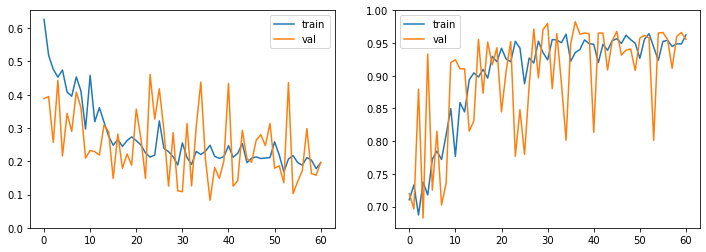

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6706 - accuracy: 0.5846 - precision: 0.9537 - recall: 0.5812 - f1: 0.6983 - specificity: 0.5495 - negative_predictive_value: 0.1104 - matthews_correlation_coefficient: 0.1142 - val_loss: 0.7863 - val_accuracy: 0.4831 - val_precision: 0.9449 - val_recall: 0.4472 - val_f1: 0.6033 - val_specificity: 0.6748 - val_negative_predictive_value: 0.0931 - val_matthews_correlation_coefficient: 0.1132

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11318, saving model to ../models/autoencoders_requirements/pixelation_2020_03_24-23_17_08.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6428 - accuracy: 0.6074 - precision: 0.9634 - recall: 0.6034 - f1: 0.7316 - specificity: 0.5657 - negative_predictive_value: 0.1121 - matthews_correlation_coefficient: 0.1259 - val_loss: 0.6343 - val_accuracy: 0.5265 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.22452
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5293 - accuracy: 0.7000 - precision: 0.9760 - recall: 0.6954 - f1: 0.8076 - specificity: 0.6803 - negative_predictive_value: 0.1581 - matthews_correlation_coefficient: 0.2283 - val_loss: 0.3293 - val_accuracy: 0.8742 - val_precision: 0.9531 - val_recall: 0.9148 - val_f1: 0.9323 - val_specificity: 0.2554 - val_negative_predictive_value: 0.1896 - val_matthews_correlation_coefficient: 0.1586

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.22452
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5211 - accuracy: 0.7117 - precision: 0.9778 - recall: 0.7097 - f1: 0.8183 - specificity: 0.6851 - negative_predictive_value: 0.1641 - matthews_correlation_coefficient: 0.2381 - val_loss: 0.2617 - val_accuracy: 0.9150 - val_precision: 0.9493 - val_recall: 0.9633 - val_f1: 0.9553 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.22718
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5085 - accuracy: 0.7271 - precision: 0.9761 - recall: 0.7277 - f1: 0.8264 - specificity: 0.6652 - negative_predictive_value: 0.1807 - matthews_correlation_coefficient: 0.2465 - val_loss: 0.3992 - val_accuracy: 0.7537 - val_precision: 0.9750 - val_recall: 0.7634 - val_f1: 0.8541 - val_specificity: 0.5914 - val_negative_predictive_value: 0.1651 - val_matthews_correlation_coefficient: 0.2240

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.22718
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5026 - accuracy: 0.7174 - precision: 0.9785 - recall: 0.7145 - f1: 0.8219 - specificity: 0.7031 - negative_predictive_value: 0.1709 - matthews_correlation_coefficient: 0.2511 - val_loss: 0.3066 - val_accuracy: 0.8326 - val_precision: 0.9624 - val_recall: 0.8602 - val_f1: 0.9063 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.22718
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4704 - accuracy: 0.7482 - precision: 0.9809 - recall: 0.7460 - f1: 0.8453 - specificity: 0.7386 - negative_predictive_value: 0.1856 - matthews_correlation_coefficient: 0.2826 - val_loss: 0.3068 - val_accuracy: 0.8448 - val_precision: 0.9571 - val_recall: 0.8780 - val_f1: 0.9144 - val_specificity: 0.3590 - val_negative_predictive_value: 0.1685 - val_matthews_correlation_coefficient: 0.1712

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.22718
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4724 - accuracy: 0.7375 - precision: 0.9779 - recall: 0.7352 - f1: 0.8351 - specificity: 0.6940 - negative_predictive_value: 0.1801 - matthews_correlation_coefficient: 0.2676 - val_loss: 0.4015 - val_accuracy: 0.7415 - val_precision: 0.9743 - val_recall: 0.7501 - val_f1: 0.8453 - val_spe

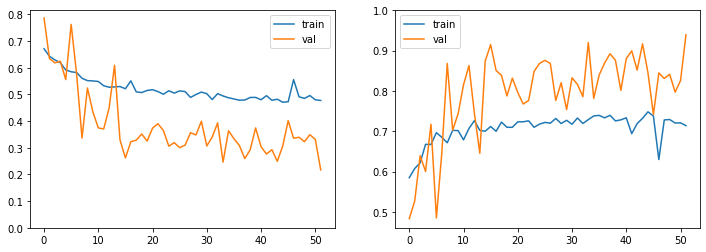

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5582 - accuracy: 0.7004 - precision: 0.9242 - recall: 0.6589 - f1: 0.7636 - specificity: 0.8334 - negative_predictive_value: 0.4418 - matthews_correlation_coefficient: 0.4231 - val_loss: 0.5097 - val_accuracy: 0.7259 - val_precision: 0.9159 - val_recall: 0.6650 - val_f1: 0.7655 - val_specificity: 0.8533 - val_negative_predictive_value: 0.4612 - val_matthews_correlation_coefficient: 0.4668

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.46682, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_24-23_24_52.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5327 - accuracy: 0.7221 - precision: 0.9309 - recall: 0.6825 - f1: 0.7838 - specificity: 0.8437 - negative_predictive_value: 0.4610 - matthews_correlation_coefficient: 0.4525 - val_loss: 0.4994 - val_accuracy: 0.7259 - val_preci

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4880 - accuracy: 0.7516 - precision: 0.9333 - recall: 0.7242 - f1: 0.8119 - specificity: 0.8356 - negative_predictive_value: 0.4935 - matthews_correlation_coefficient: 0.4865 - val_loss: 0.4780 - val_accuracy: 0.7528 - val_precision: 0.9145 - val_recall: 0.7019 - val_f1: 0.7907 - val_specificity: 0.8473 - val_negative_predictive_value: 0.4879 - val_matthews_correlation_coefficient: 0.4948

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.51572
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4879 - accuracy: 0.7549 - precision: 0.9324 - recall: 0.7300 - f1: 0.8143 - specificity: 0.8240 - negative_predictive_value: 0.4994 - matthews_correlation_coefficient: 0.4879 - val_loss: 0.5627 - val_accuracy: 0.7233 - val_precision: 0.9189 - val_recall: 0.6573 - val_f1: 0.7627 - val_specificity: 0.8607 - val_negative_predictive_value: 0.4542 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient improved from 0.51946 to 0.52618, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_24-23_24_52.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4674 - accuracy: 0.7651 - precision: 0.9313 - recall: 0.7439 - f1: 0.8236 - specificity: 0.8272 - negative_predictive_value: 0.5123 - matthews_correlation_coefficient: 0.5023 - val_loss: 0.4303 - val_accuracy: 0.8005 - val_precision: 0.8917 - val_recall: 0.7957 - val_f1: 0.8356 - val_specificity: 0.7590 - val_negative_predictive_value: 0.5713 - val_matthews_correlation_coefficient: 0.5296

Epoch 00030: val_matthews_correlation_coefficient improved from 0.52618 to 0.52964, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_24-23_24_52.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4688 - accuracy: 0.7623 - precision: 0.9262 - recall: 0.7330 - f1: 0.8138 - specificity: 0.840

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4596 - accuracy: 0.7625 - precision: 0.9320 - recall: 0.7406 - f1: 0.8208 - specificity: 0.8272 - negative_predictive_value: 0.5108 - matthews_correlation_coefficient: 0.5002 - val_loss: 0.4413 - val_accuracy: 0.7927 - val_precision: 0.8993 - val_recall: 0.7749 - val_f1: 0.8271 - val_specificity: 0.7916 - val_negative_predictive_value: 0.5549 - val_matthews_correlation_coefficient: 0.5309

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.53869
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4591 - accuracy: 0.7694 - precision: 0.9347 - recall: 0.7526 - f1: 0.8289 - specificity: 0.8433 - negative_predictive_value: 0.5321 - matthews_correlation_coefficient: 0.5244 - val_loss: 0.5234 - val_accuracy: 0.7493 - val_precision: 0.9215 - val_recall: 0.6916 - val_f1: 0.7861 - val_specificity: 0.8615 - val_negative_predictive_value: 0.4834 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.54515
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4417 - accuracy: 0.7772 - precision: 0.9373 - recall: 0.7553 - f1: 0.8326 - specificity: 0.8309 - negative_predictive_value: 0.5300 - matthews_correlation_coefficient: 0.5232 - val_loss: 0.4760 - val_accuracy: 0.7754 - val_precision: 0.9073 - val_recall: 0.7402 - val_f1: 0.8112 - val_specificity: 0.8182 - val_negative_predictive_value: 0.5199 - val_matthews_correlation_coefficient: 0.5130

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.54515
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4452 - accuracy: 0.7820 - precision: 0.9329 - recall: 0.7629 - f1: 0.8360 - specificity: 0.8302 - negative_predictive_value: 0.5352 - matthews_correlation_coefficient: 0.5260 - val_loss: 0.4874 - val_accuracy: 0.7840 - val_precision: 0.9126 - val_recall: 0.7487 - val_f1: 0.8183 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.54515
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4293 - accuracy: 0.7950 - precision: 0.9363 - recall: 0.7828 - f1: 0.8499 - specificity: 0.8302 - negative_predictive_value: 0.5517 - matthews_correlation_coefficient: 0.5449 - val_loss: 0.4788 - val_accuracy: 0.7745 - val_precision: 0.9162 - val_recall: 0.7324 - val_f1: 0.8092 - val_specificity: 0.8428 - val_negative_predictive_value: 0.5192 - val_matthews_correlation_coefficient: 0.5249

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.54515
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4296 - accuracy: 0.7915 - precision: 0.9379 - recall: 0.7784 - f1: 0.8477 - specificity: 0.8358 - negative_predictive_value: 0.5504 - matthews_correlation_coefficient: 0.5450 - val_loss: 0.5341 - val_accuracy: 0.7407 - val_precision: 0.9240 - val_recall: 0.6790 - val_f1: 0.7786 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4126 - accuracy: 0.7939 - precision: 0.9356 - recall: 0.7797 - f1: 0.8459 - specificity: 0.8386 - negative_predictive_value: 0.5536 - matthews_correlation_coefficient: 0.5495 - val_loss: 0.4917 - val_accuracy: 0.7650 - val_precision: 0.9206 - val_recall: 0.7143 - val_f1: 0.8003 - val_specificity: 0.8558 - val_negative_predictive_value: 0.5018 - val_matthews_correlation_coefficient: 0.5154

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.54616
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4434 - accuracy: 0.7794 - precision: 0.9327 - recall: 0.7513 - f1: 0.8277 - specificity: 0.8430 - negative_predictive_value: 0.5390 - matthews_correlation_coefficient: 0.5281 - val_loss: 0.5949 - val_accuracy: 0.7259 - val_precision: 0.9269 - val_recall: 0.6561 - val_f1: 0.7643 - val_specificity: 0.8752 - val_negative_predictive_value: 0.4578 - val_matthews_correlation_coefficie

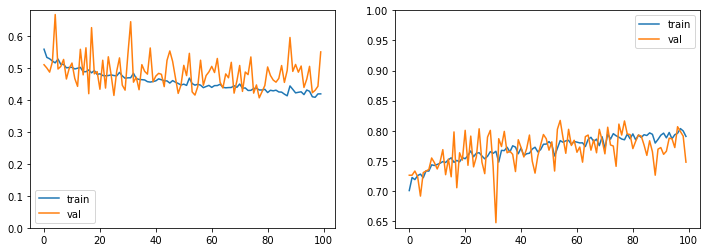

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6527 - accuracy: 0.5553 - precision: 0.8846 - recall: 0.5000 - f1: 0.6281 - specificity: 0.7532 - negative_predictive_value: 0.3009 - matthews_correlation_coefficient: 0.2173 - val_loss: 0.6177 - val_accuracy: 0.5637 - val_precision: 0.8592 - val_recall: 0.5353 - val_f1: 0.6530 - val_specificity: 0.6835 - val_negative_predictive_value: 0.2899 - val_matthews_correlation_coefficient: 0.1798

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.17982, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_24-23_39_37.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6511 - accuracy: 0.5536 - precision: 0.8840 - recall: 0.4931 - f1: 0.6225 - specificity: 0.7545 - negative_predictive_value: 0.3009 - matthews_correlation_coefficient: 0.2133 - val_loss: 0.7158 - val_accuracy: 0.4744 - val_precision:


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.27840
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6027 - accuracy: 0.6655 - precision: 0.8875 - recall: 0.6570 - f1: 0.7456 - specificity: 0.7042 - negative_predictive_value: 0.3788 - matthews_correlation_coefficient: 0.3081 - val_loss: 0.5574 - val_accuracy: 0.7060 - val_precision: 0.8690 - val_recall: 0.7388 - val_f1: 0.7957 - val_specificity: 0.5911 - val_negative_predictive_value: 0.3872 - val_matthews_correlation_coefficient: 0.2895

Epoch 00015: val_matthews_correlation_coefficient improved from 0.27840 to 0.28953, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_24-23_39_37.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6008 - accuracy: 0.6701 - precision: 0.8795 - recall: 0.6608 - f1: 0.7430 - specificity: 0.6887 - negative_predictive_value: 0.3875 - matthews_correlation_coefficient: 0.3036 - val_loss: 0.7493 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5638 - accuracy: 0.7069 - precision: 0.8967 - recall: 0.7096 - f1: 0.7853 - specificity: 0.7015 - negative_predictive_value: 0.4151 - matthews_correlation_coefficient: 0.3543 - val_loss: 0.6110 - val_accuracy: 0.6496 - val_precision: 0.8978 - val_recall: 0.6272 - val_f1: 0.7345 - val_specificity: 0.7324 - val_negative_predictive_value: 0.3568 - val_matthews_correlation_coefficient: 0.3016

Epoch 00029: val_matthews_correlation_coefficient improved from 0.30105 to 0.30155, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_24-23_39_37.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5561 - accuracy: 0.7030 - precision: 0.8968 - recall: 0.6951 - f1: 0.7774 - specificity: 0.7177 - negative_predictive_value: 0.4092 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.5716 - val_accuracy: 0.7060 - val_precision: 0.8593 - val_recall: 0.7502 - val_f1: 0.7984 - val_spec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5522 - accuracy: 0.7098 - precision: 0.9056 - recall: 0.7031 - f1: 0.7843 - specificity: 0.7344 - negative_predictive_value: 0.4232 - matthews_correlation_coefficient: 0.3776 - val_loss: 0.6311 - val_accuracy: 0.6435 - val_precision: 0.8915 - val_recall: 0.6264 - val_f1: 0.7312 - val_specificity: 0.7144 - val_negative_predictive_value: 0.3481 - val_matthews_correlation_coefficient: 0.2848

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.31825
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5483 - accuracy: 0.7098 - precision: 0.9029 - recall: 0.7056 - f1: 0.7858 - specificity: 0.7500 - negative_predictive_value: 0.4350 - matthews_correlation_coefficient: 0.3890 - val_loss: 0.7437 - val_accuracy: 0.5950 - val_precision: 0.9177 - val_recall: 0.5364 - val_f1: 0.6712 - val_specificity: 0.8172 - val_negative_predictive_value: 0.3308 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.32362
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5360 - accuracy: 0.7095 - precision: 0.9037 - recall: 0.7015 - f1: 0.7840 - specificity: 0.7332 - negative_predictive_value: 0.4209 - matthews_correlation_coefficient: 0.3741 - val_loss: 0.5813 - val_accuracy: 0.6791 - val_precision: 0.9076 - val_recall: 0.6619 - val_f1: 0.7619 - val_specificity: 0.7437 - val_negative_predictive_value: 0.3831 - val_matthews_correlation_coefficient: 0.3424

Epoch 00058: val_matthews_correlation_coefficient improved from 0.32362 to 0.34240, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_24-23_39_37.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5327 - accuracy: 0.7193 - precision: 0.9033 - recall: 0.7180 - f1: 0.7936 - specificity: 0.7118 - negative_predictive_value: 0.4354 - matthews_correlation_coefficient: 0.3785 - val_loss: 0.6295 - 


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.34240
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5260 - accuracy: 0.7232 - precision: 0.9069 - recall: 0.7178 - f1: 0.7938 - specificity: 0.7322 - negative_predictive_value: 0.4355 - matthews_correlation_coefficient: 0.3901 - val_loss: 0.5737 - val_accuracy: 0.7008 - val_precision: 0.8900 - val_recall: 0.7116 - val_f1: 0.7873 - val_specificity: 0.6658 - val_negative_predictive_value: 0.3884 - val_matthews_correlation_coefficient: 0.3227

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.34240
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5222 - accuracy: 0.7312 - precision: 0.9071 - recall: 0.7311 - f1: 0.8042 - specificity: 0.7332 - negative_predictive_value: 0.4442 - matthews_correlation_coefficient: 0.4011 - val_loss: 0.6206 - val_accuracy: 0.6409 - val_precision: 0.9096 - val_recall: 0.6073 - val_f1: 0.7228 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.34453
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5029 - accuracy: 0.7449 - precision: 0.9157 - recall: 0.7393 - f1: 0.8130 - specificity: 0.7487 - negative_predictive_value: 0.4617 - matthews_correlation_coefficient: 0.4276 - val_loss: 0.6984 - val_accuracy: 0.6236 - val_precision: 0.9086 - val_recall: 0.5836 - val_f1: 0.7045 - val_specificity: 0.7843 - val_negative_predictive_value: 0.3470 - val_matthews_correlation_coefficient: 0.3054

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.34453
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5142 - accuracy: 0.7321 - precision: 0.9192 - recall: 0.7196 - f1: 0.7991 - specificity: 0.7759 - negative_predictive_value: 0.4534 - matthews_correlation_coefficient: 0.4267 - val_loss: 0.5892 - val_accuracy: 0.6722 - val_precision: 0.8997 - val_recall: 0.6626 - val_f1: 0.7580 - val_spe

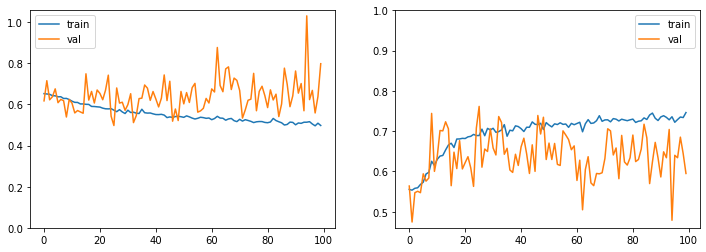

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4816 - accuracy: 0.7668 - precision: 0.8271 - recall: 0.7803 - f1: 0.7913 - specificity: 0.7557 - negative_predictive_value: 0.7172 - matthews_correlation_coefficient: 0.5394 - val_loss: 0.3816 - val_accuracy: 0.8248 - val_precision: 0.8386 - val_recall: 0.8760 - val_f1: 0.8536 - val_specificity: 0.7346 - val_negative_predictive_value: 0.7796 - val_matthews_correlation_coefficient: 0.6138

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.61383, saving model to ../models/autoencoders_requirements/varied_background_2020_03_24-23_54_21.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4158 - accuracy: 0.7931 - precision: 0.8485 - recall: 0.8093 - f1: 0.8175 - specificity: 0.7785 - negative_predictive_value: 0.7481 - matthews_correlation_coefficient: 0.5913 - val_loss: 0.3652 - val_accuracy: 0.8300 - val_prec


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.67512
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3418 - accuracy: 0.8319 - precision: 0.8711 - recall: 0.8481 - f1: 0.8524 - specificity: 0.8172 - negative_predictive_value: 0.7961 - matthews_correlation_coefficient: 0.6652 - val_loss: 0.3159 - val_accuracy: 0.8595 - val_precision: 0.9015 - val_recall: 0.8511 - val_f1: 0.8739 - val_specificity: 0.8495 - val_negative_predictive_value: 0.7787 - val_matthews_correlation_coefficient: 0.6901

Epoch 00015: val_matthews_correlation_coefficient improved from 0.67512 to 0.69014, saving model to ../models/autoencoders_requirements/varied_background_2020_03_24-23_54_21.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3327 - accuracy: 0.8421 - precision: 0.8786 - recall: 0.8582 - f1: 0.8608 - specificity: 0.8181 - negative_predictive_value: 0.8029 - matthews_correlation_coefficient: 0.6797 - val_loss: 0.3

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3131 - accuracy: 0.8536 - precision: 0.8821 - recall: 0.8742 - f1: 0.8730 - specificity: 0.8279 - negative_predictive_value: 0.8126 - matthews_correlation_coefficient: 0.6995 - val_loss: 0.3028 - val_accuracy: 0.8586 - val_precision: 0.8513 - val_recall: 0.9231 - val_f1: 0.8823 - val_specificity: 0.7528 - val_negative_predictive_value: 0.8533 - val_matthews_correlation_coefficient: 0.6891

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.72075
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3215 - accuracy: 0.8416 - precision: 0.8805 - recall: 0.8562 - f1: 0.8613 - specificity: 0.8340 - negative_predictive_value: 0.8032 - matthews_correlation_coefficient: 0.6862 - val_loss: 0.2957 - val_accuracy: 0.8656 - val_precision: 0.8799 - val_recall: 0.8957 - val_f1: 0.8849 - val_specificity: 0.8017 - val_negative_predictive_value: 0.8244 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3022 - accuracy: 0.8547 - precision: 0.8862 - recall: 0.8613 - f1: 0.8678 - specificity: 0.8483 - negative_predictive_value: 0.8150 - matthews_correlation_coefficient: 0.7065 - val_loss: 0.3485 - val_accuracy: 0.8257 - val_precision: 0.9263 - val_recall: 0.7607 - val_f1: 0.8326 - val_specificity: 0.8984 - val_negative_predictive_value: 0.7032 - val_matthews_correlation_coefficient: 0.6435

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.74106
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3052 - accuracy: 0.8551 - precision: 0.8918 - recall: 0.8688 - f1: 0.8738 - specificity: 0.8446 - negative_predictive_value: 0.8214 - matthews_correlation_coefficient: 0.7127 - val_loss: 0.3037 - val_accuracy: 0.8422 - val_precision: 0.9167 - val_recall: 0.8024 - val_f1: 0.8524 - val_specificity: 0.8799 - val_negative_predictive_value: 0.7383 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2863 - accuracy: 0.8657 - precision: 0.8980 - recall: 0.8798 - f1: 0.8844 - specificity: 0.8473 - negative_predictive_value: 0.8250 - matthews_correlation_coefficient: 0.7246 - val_loss: 0.2831 - val_accuracy: 0.8708 - val_precision: 0.8319 - val_recall: 0.9786 - val_f1: 0.8964 - val_specificity: 0.6974 - val_negative_predictive_value: 0.9430 - val_matthews_correlation_coefficient: 0.7222

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.76339
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2873 - accuracy: 0.8677 - precision: 0.8931 - recall: 0.8838 - f1: 0.8837 - specificity: 0.8447 - negative_predictive_value: 0.8285 - matthews_correlation_coefficient: 0.7261 - val_loss: 0.2557 - val_accuracy: 0.8846 - val_precision: 0.8669 - val_recall: 0.9440 - val_f1: 0.9019 - val_specificity: 0.7781 - val_negative_predictive_value: 0.8932 - val_matthews_correlation_coefficie


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.76785
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2771 - accuracy: 0.8746 - precision: 0.9023 - recall: 0.8912 - f1: 0.8929 - specificity: 0.8624 - negative_predictive_value: 0.8416 - matthews_correlation_coefficient: 0.7481 - val_loss: 0.2739 - val_accuracy: 0.8708 - val_precision: 0.8963 - val_recall: 0.8826 - val_f1: 0.8866 - val_specificity: 0.8390 - val_negative_predictive_value: 0.8118 - val_matthews_correlation_coefficient: 0.7145

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.76785
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2761 - accuracy: 0.8722 - precision: 0.8980 - recall: 0.8772 - f1: 0.8825 - specificity: 0.8669 - negative_predictive_value: 0.8344 - matthews_correlation_coefficient: 0.7394 - val_loss: 0.2418 - val_accuracy: 0.9020 - val_precision: 0.8862 - val_recall: 0.9514 - val_f1: 0.9155 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2618 - accuracy: 0.8787 - precision: 0.9067 - recall: 0.8888 - f1: 0.8931 - specificity: 0.8578 - negative_predictive_value: 0.8428 - matthews_correlation_coefficient: 0.7491 - val_loss: 0.2468 - val_accuracy: 0.8942 - val_precision: 0.8975 - val_recall: 0.9253 - val_f1: 0.9089 - val_specificity: 0.8316 - val_negative_predictive_value: 0.8638 - val_matthews_correlation_coefficient: 0.7588

Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.78617
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2678 - accuracy: 0.8816 - precision: 0.9093 - recall: 0.8919 - f1: 0.8962 - specificity: 0.8653 - negative_predictive_value: 0.8427 - matthews_correlation_coefficient: 0.7559 - val_loss: 0.3043 - val_accuracy: 0.8543 - val_precision: 0.8298 - val_recall: 0.9488 - val_f1: 0.8816 - val_specificity: 0.7071 - val_negative_predictive_value: 0.8889 - val_matthews_correlation_coefficie


Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.79170

   Final Accuracy:  90.55%
  Final Precision:  89.55%
     Final Recall:  95.18%
  Final F-measure:  92.27%
Final Specificity:  83.80%
        Final NPV:  92.25%
        Final MCC:  80.37%
[[393  76]
 [ 33 651]]
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       469
           1       0.90      0.95      0.92       684

    accuracy                           0.91      1153
   macro avg       0.91      0.89      0.90      1153
weighted avg       0.91      0.91      0.90      1153



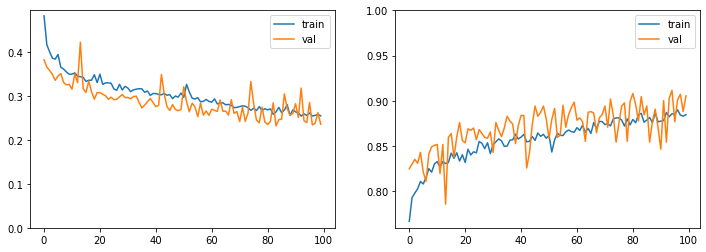

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5785 - accuracy: 0.7059 - precision: 0.9148 - recall: 0.6881 - f1: 0.7779 - specificity: 0.7651 - negative_predictive_value: 0.4219 - matthews_correlation_coefficient: 0.3885 - val_loss: 0.6050 - val_accuracy: 0.6964 - val_precision: 0.9056 - val_recall: 0.6428 - val_f1: 0.7480 - val_specificity: 0.8029 - val_negative_predictive_value: 0.4044 - val_matthews_correlation_coefficient: 0.3980

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.39799, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_25-00_09_05.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5607 - accuracy: 0.7124 - precision: 0.9239 - recall: 0.6837 - f1: 0.7822 - specificity: 0.8015 - negative_predictive_value: 0.4180 - matthews_correlation_coefficient: 0.4052 - val_loss: 0.5677 - val_accuracy: 0.6973 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5420 - accuracy: 0.7158 - precision: 0.9338 - recall: 0.6810 - f1: 0.7843 - specificity: 0.8243 - negative_predictive_value: 0.4266 - matthews_correlation_coefficient: 0.4254 - val_loss: 0.5422 - val_accuracy: 0.7060 - val_precision: 0.9022 - val_recall: 0.6591 - val_f1: 0.7575 - val_specificity: 0.7875 - val_negative_predictive_value: 0.4120 - val_matthews_correlation_coefficient: 0.4009

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.40294
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5406 - accuracy: 0.7221 - precision: 0.9341 - recall: 0.6887 - f1: 0.7902 - specificity: 0.8238 - negative_predictive_value: 0.4317 - matthews_correlation_coefficient: 0.4320 - val_loss: 0.5290 - val_accuracy: 0.7016 - val_precision: 0.9016 - val_recall: 0.6539 - val_f1: 0.7540 - val_specificity: 0.7875 - val_negative_predictive_value: 0.4078 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5350 - accuracy: 0.7191 - precision: 0.9342 - recall: 0.6843 - f1: 0.7866 - specificity: 0.8208 - negative_predictive_value: 0.4306 - matthews_correlation_coefficient: 0.4292 - val_loss: 0.5485 - val_accuracy: 0.7034 - val_precision: 0.8944 - val_recall: 0.6617 - val_f1: 0.7575 - val_specificity: 0.7677 - val_negative_predictive_value: 0.4084 - val_matthews_correlation_coefficient: 0.3867

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41204
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5363 - accuracy: 0.7200 - precision: 0.9271 - recall: 0.6812 - f1: 0.7824 - specificity: 0.8375 - negative_predictive_value: 0.4417 - matthews_correlation_coefficient: 0.4361 - val_loss: 0.5704 - val_accuracy: 0.7025 - val_precision: 0.9008 - val_recall: 0.6548 - val_f1: 0.7550 - val_specificity: 0.7858 - val_negative_predictive_value: 0.4084 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5282 - accuracy: 0.7260 - precision: 0.9310 - recall: 0.6973 - f1: 0.7935 - specificity: 0.8248 - negative_predictive_value: 0.4370 - matthews_correlation_coefficient: 0.4390 - val_loss: 0.5414 - val_accuracy: 0.7025 - val_precision: 0.9012 - val_recall: 0.6555 - val_f1: 0.7551 - val_specificity: 0.7876 - val_negative_predictive_value: 0.4101 - val_matthews_correlation_coefficient: 0.3975

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.41513
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5263 - accuracy: 0.7232 - precision: 0.9329 - recall: 0.6946 - f1: 0.7931 - specificity: 0.8321 - negative_predictive_value: 0.4444 - matthews_correlation_coefficient: 0.4429 - val_loss: 0.5703 - val_accuracy: 0.6999 - val_precision: 0.9044 - val_recall: 0.6485 - val_f1: 0.7517 - val_specificity: 0.7971 - val_negative_predictive_value: 0.4074 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5276 - accuracy: 0.7195 - precision: 0.9345 - recall: 0.6880 - f1: 0.7888 - specificity: 0.8299 - negative_predictive_value: 0.4361 - matthews_correlation_coefficient: 0.4354 - val_loss: 0.5281 - val_accuracy: 0.7216 - val_precision: 0.8925 - val_recall: 0.6877 - val_f1: 0.7743 - val_specificity: 0.7567 - val_negative_predictive_value: 0.4271 - val_matthews_correlation_coefficient: 0.4030

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.41513
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5202 - accuracy: 0.7295 - precision: 0.9272 - recall: 0.6953 - f1: 0.7915 - specificity: 0.8267 - negative_predictive_value: 0.4449 - matthews_correlation_coefficient: 0.4381 - val_loss: 0.5551 - val_accuracy: 0.7034 - val_precision: 0.9052 - val_recall: 0.6530 - val_f1: 0.7547 - val_specificity: 0.7978 - val_negative_predictive_value: 0.4117 - val_matthews_correlation_coefficie

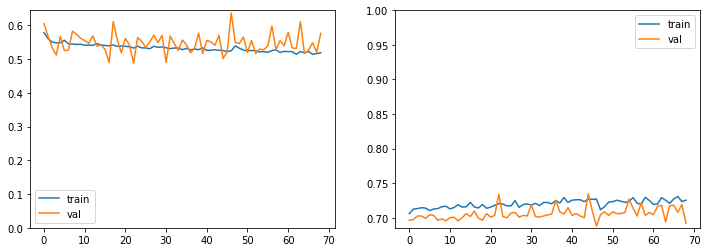

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6120 - accuracy: 0.6668 - precision: 0.7201 - recall: 0.6147 - f1: 0.6244 - specificity: 0.7156 - negative_predictive_value: 0.6632 - matthews_correlation_coefficient: 0.3589 - val_loss: 0.6501 - val_accuracy: 0.6045 - val_precision: 0.8233 - val_recall: 0.3674 - val_f1: 0.4940 - val_specificity: 0.8804 - val_negative_predictive_value: 0.5283 - val_matthews_correlation_coefficient: 0.2932

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29324, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_25-00_19_21.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5553 - accuracy: 0.7137 - precision: 0.7511 - recall: 0.7365 - f1: 0.7210 - specificity: 0.6891 - negative_predictive_value: 0.7094 - matthews_correlation_coefficient: 0.4431 - val_loss: 0.5478 - val_accuracy: 0.7268 - v


Epoch 00014: val_matthews_correlation_coefficient improved from 0.52343 to 0.55197, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_25-00_19_21.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4267 - accuracy: 0.7898 - precision: 0.7967 - recall: 0.8261 - f1: 0.8018 - specificity: 0.7513 - negative_predictive_value: 0.7877 - matthews_correlation_coefficient: 0.5823 - val_loss: 0.4746 - val_accuracy: 0.7615 - val_precision: 0.8122 - val_recall: 0.7422 - val_f1: 0.7697 - val_specificity: 0.7701 - val_negative_predictive_value: 0.6978 - val_matthews_correlation_coefficient: 0.5109

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55197
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4267 - accuracy: 0.7874 - precision: 0.8034 - recall: 0.8083 - f1: 0.7967 - specificity: 0.7634 - negative_predictive_value: 0.7778 - matthews_correlation_coefficient: 0.5775 - val_lo

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4047 - accuracy: 0.8011 - precision: 0.8065 - recall: 0.8235 - f1: 0.8076 - specificity: 0.7727 - negative_predictive_value: 0.8054 - matthews_correlation_coefficient: 0.6034 - val_loss: 0.4810 - val_accuracy: 0.7780 - val_precision: 0.7785 - val_recall: 0.8408 - val_f1: 0.8038 - val_specificity: 0.6881 - val_negative_predictive_value: 0.7646 - val_matthews_correlation_coefficient: 0.5353

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.55707
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4032 - accuracy: 0.8028 - precision: 0.8183 - recall: 0.8254 - f1: 0.8140 - specificity: 0.7837 - negative_predictive_value: 0.7986 - matthews_correlation_coefficient: 0.6125 - val_loss: 0.4927 - val_accuracy: 0.7650 - val_precision: 0.8093 - val_recall: 0.7528 - val_f1: 0.7745 - val_specificity: 0.7645 - val_negative_predictive_value: 0.7064 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3822 - accuracy: 0.8145 - precision: 0.8329 - recall: 0.8264 - f1: 0.8222 - specificity: 0.8034 - negative_predictive_value: 0.7954 - matthews_correlation_coefficient: 0.6304 - val_loss: 0.4659 - val_accuracy: 0.7728 - val_precision: 0.8336 - val_recall: 0.7406 - val_f1: 0.7788 - val_specificity: 0.7932 - val_negative_predictive_value: 0.7005 - val_matthews_correlation_coefficient: 0.5336

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.58891
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3850 - accuracy: 0.8152 - precision: 0.8330 - recall: 0.8258 - f1: 0.8231 - specificity: 0.8079 - negative_predictive_value: 0.8057 - matthews_correlation_coefficient: 0.6359 - val_loss: 0.4548 - val_accuracy: 0.7849 - val_precision: 0.8238 - val_recall: 0.7726 - val_f1: 0.7921 - val_specificity: 0.7769 - val_negative_predictive_value: 0.7286 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.59293
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3762 - accuracy: 0.8206 - precision: 0.8469 - recall: 0.8220 - f1: 0.8276 - specificity: 0.8151 - negative_predictive_value: 0.7994 - matthews_correlation_coefficient: 0.6411 - val_loss: 0.4735 - val_accuracy: 0.7710 - val_precision: 0.7385 - val_recall: 0.9115 - val_f1: 0.8115 - val_specificity: 0.5917 - val_negative_predictive_value: 0.8331 - val_matthews_correlation_coefficient: 0.5345

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.59293
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3665 - accuracy: 0.8247 - precision: 0.8332 - recall: 0.8374 - f1: 0.8289 - specificity: 0.8011 - negative_predictive_value: 0.8089 - matthews_correlation_coefficient: 0.6469 - val_loss: 0.5199 - val_accuracy: 0.7641 - val_precision: 0.7966 - val_recall: 0.7730 - val_f1: 0.7797 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.59293
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3643 - accuracy: 0.8265 - precision: 0.8448 - recall: 0.8230 - f1: 0.8269 - specificity: 0.8238 - negative_predictive_value: 0.8121 - matthews_correlation_coefficient: 0.6532 - val_loss: 0.4567 - val_accuracy: 0.7971 - val_precision: 0.8127 - val_recall: 0.8246 - val_f1: 0.8139 - val_specificity: 0.7462 - val_negative_predictive_value: 0.7618 - val_matthews_correlation_coefficient: 0.5725

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.59293
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3606 - accuracy: 0.8249 - precision: 0.8427 - recall: 0.8336 - f1: 0.8311 - specificity: 0.8145 - negative_predictive_value: 0.8066 - matthews_correlation_coefficient: 0.6502 - val_loss: 0.4279 - val_accuracy: 0.8040 - val_precision: 0.7908 - val_recall: 0.8720 - val_f1: 0.8264 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.61325
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3633 - accuracy: 0.8280 - precision: 0.8433 - recall: 0.8446 - f1: 0.8369 - specificity: 0.8075 - negative_predictive_value: 0.8181 - matthews_correlation_coefficient: 0.6562 - val_loss: 0.4430 - val_accuracy: 0.8014 - val_precision: 0.7789 - val_recall: 0.8895 - val_f1: 0.8275 - val_specificity: 0.6742 - val_negative_predictive_value: 0.8281 - val_matthews_correlation_coefficient: 0.5835

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.61325
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3458 - accuracy: 0.8386 - precision: 0.8400 - recall: 0.8520 - f1: 0.8412 - specificity: 0.8183 - negative_predictive_value: 0.8351 - matthews_correlation_coefficient: 0.6742 - val_loss: 0.4462 - val_accuracy: 0.8040 - val_precision: 0.7947 - val_recall: 0.8704 - val_f1: 0.8275 - val_spe

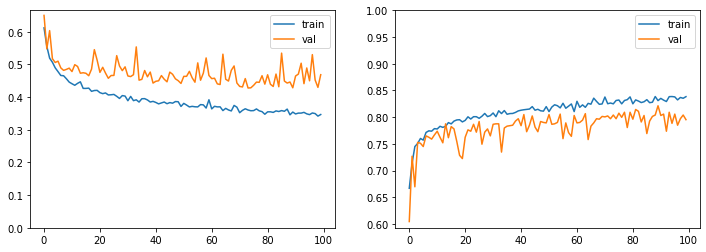

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6398 - accuracy: 0.5505 - precision: 0.8904 - recall: 0.4830 - f1: 0.6112 - specificity: 0.7789 - negative_predictive_value: 0.3077 - matthews_correlation_coefficient: 0.2291 - val_loss: 0.5584 - val_accuracy: 0.6687 - val_precision: 0.8077 - val_recall: 0.7606 - val_f1: 0.7810 - val_specificity: 0.3749 - val_negative_predictive_value: 0.3144 - val_matthews_correlation_coefficient: 0.1270

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.12700, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_25-00_34_13.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6372 - accuracy: 0.5512 - precision: 0.8859 - recall: 0.4845 - f1: 0.6080 - specificity: 0.7687 - negative_predictive_value: 0.3104 - matthews_correlation_coefficient: 0.2264 - val_loss: 0.7019 - val_accuracy: 0.5022 - val_precision: 0


Epoch 00014: val_matthews_correlation_coefficient improved from 0.29992 to 0.30456, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_25-00_34_13.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5841 - accuracy: 0.6458 - precision: 0.9091 - recall: 0.6052 - f1: 0.7172 - specificity: 0.7839 - negative_predictive_value: 0.3743 - matthews_correlation_coefficient: 0.3303 - val_loss: 0.5902 - val_accuracy: 0.6592 - val_precision: 0.8742 - val_recall: 0.6582 - val_f1: 0.7476 - val_specificity: 0.6663 - val_negative_predictive_value: 0.3633 - val_matthews_correlation_coefficient: 0.2766

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.30456
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5824 - accuracy: 0.6544 - precision: 0.8915 - recall: 0.6220 - f1: 0.7252 - specificity: 0.7511 - negative_predictive_value: 0.3749 - matthews_correlation_coefficient: 0.3147 - val_loss: 0.6472 - val

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5526 - accuracy: 0.6859 - precision: 0.9075 - recall: 0.6621 - f1: 0.7576 - specificity: 0.7583 - negative_predictive_value: 0.4029 - matthews_correlation_coefficient: 0.3596 - val_loss: 0.6173 - val_accuracy: 0.6357 - val_precision: 0.8935 - val_recall: 0.6113 - val_f1: 0.7221 - val_specificity: 0.7226 - val_negative_predictive_value: 0.3503 - val_matthews_correlation_coefficient: 0.2841

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.33611
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5489 - accuracy: 0.6950 - precision: 0.9103 - recall: 0.6757 - f1: 0.7685 - specificity: 0.7591 - negative_predictive_value: 0.4123 - matthews_correlation_coefficient: 0.3716 - val_loss: 0.4853 - val_accuracy: 0.7797 - val_precision: 0.8284 - val_recall: 0.9095 - val_f1: 0.8655 - val_specificity: 0.3412 - val_negative_predictive_value: 0.5191 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient improved from 0.34731 to 0.35410, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_25-00_34_13.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5350 - accuracy: 0.7028 - precision: 0.9132 - recall: 0.6839 - f1: 0.7752 - specificity: 0.7844 - negative_predictive_value: 0.4323 - matthews_correlation_coefficient: 0.3993 - val_loss: 0.5976 - val_accuracy: 0.6609 - val_precision: 0.8940 - val_recall: 0.6455 - val_f1: 0.7465 - val_specificity: 0.7176 - val_negative_predictive_value: 0.3682 - val_matthews_correlation_coefficient: 0.3073

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.35410
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5378 - accuracy: 0.7082 - precision: 0.9101 - recall: 0.6905 - f1: 0.7793 - specificity: 0.7559 - negative_predictive_value: 0.4292 - matthews_correlation_coefficient: 0.3871 - val_loss: 0.6109 - val

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5222 - accuracy: 0.7124 - precision: 0.9153 - recall: 0.6893 - f1: 0.7789 - specificity: 0.7737 - negative_predictive_value: 0.4379 - matthews_correlation_coefficient: 0.4033 - val_loss: 0.5059 - val_accuracy: 0.7069 - val_precision: 0.8507 - val_recall: 0.7619 - val_f1: 0.8016 - val_specificity: 0.5255 - val_negative_predictive_value: 0.3880 - val_matthews_correlation_coefficient: 0.2609

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.37007
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5210 - accuracy: 0.7061 - precision: 0.9095 - recall: 0.6855 - f1: 0.7746 - specificity: 0.7766 - negative_predictive_value: 0.4269 - matthews_correlation_coefficient: 0.3929 - val_loss: 0.5266 - val_accuracy: 0.6973 - val_precision: 0.8750 - val_recall: 0.6654 - val_f1: 0.7538 - val_specificity: 0.7166 - val_negative_predictive_value: 0.3977 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5051 - accuracy: 0.7195 - precision: 0.9195 - recall: 0.6989 - f1: 0.7876 - specificity: 0.7798 - negative_predictive_value: 0.4414 - matthews_correlation_coefficient: 0.4130 - val_loss: 0.5250 - val_accuracy: 0.6990 - val_precision: 0.8870 - val_recall: 0.7080 - val_f1: 0.7849 - val_specificity: 0.6678 - val_negative_predictive_value: 0.3949 - val_matthews_correlation_coefficient: 0.3244

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.37007
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5073 - accuracy: 0.7208 - precision: 0.9146 - recall: 0.7062 - f1: 0.7914 - specificity: 0.7638 - negative_predictive_value: 0.4379 - matthews_correlation_coefficient: 0.4040 - val_loss: 0.6501 - val_accuracy: 0.6340 - val_precision: 0.8812 - val_recall: 0.5714 - val_f1: 0.6900 - val_specificity: 0.7625 - val_negative_predictive_value: 0.3518 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.38359
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5086 - accuracy: 0.7215 - precision: 0.9197 - recall: 0.7023 - f1: 0.7896 - specificity: 0.7877 - negative_predictive_value: 0.4464 - matthews_correlation_coefficient: 0.4209 - val_loss: 0.5913 - val_accuracy: 0.6470 - val_precision: 0.9206 - val_recall: 0.6050 - val_f1: 0.7252 - val_specificity: 0.7952 - val_negative_predictive_value: 0.3674 - val_matthews_correlation_coefficient: 0.3382

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.38359
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4987 - accuracy: 0.7234 - precision: 0.9078 - recall: 0.7036 - f1: 0.7876 - specificity: 0.7753 - negative_predictive_value: 0.4455 - matthews_correlation_coefficient: 0.4145 - val_loss: 0.4937 - val_accuracy: 0.7225 - val_precision: 0.8536 - val_recall: 0.7234 - val_f1: 0.7813 - val_spe

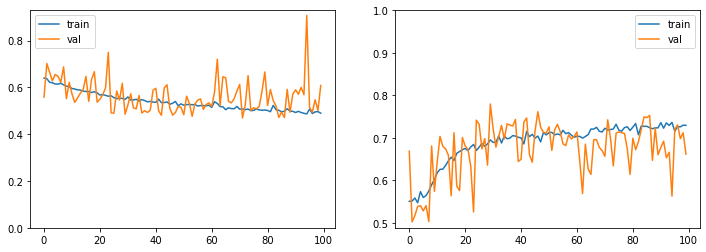

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4477 - accuracy: 0.7722 - precision: 0.8641 - recall: 0.7612 - f1: 0.8010 - specificity: 0.7918 - negative_predictive_value: 0.6493 - matthews_correlation_coefficient: 0.5436 - val_loss: 0.4143 - val_accuracy: 0.7814 - val_precision: 0.8585 - val_recall: 0.7261 - val_f1: 0.7843 - val_specificity: 0.8348 - val_negative_predictive_value: 0.6666 - val_matthews_correlation_coefficient: 0.5420

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.54204, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_25-00_49_04.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4084 - accuracy: 0.7859 - precision: 0.9037 - recall: 0.7474 - f1: 0.8107 - specificity: 0.8690 - negative_predictive_value: 0.6684 - matthews_correlation_coefficient: 0.5927 - val_loss: 0.3998 - val_accuracy: 0.7936 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.66046
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3368 - accuracy: 0.8401 - precision: 0.9267 - recall: 0.8185 - f1: 0.8646 - specificity: 0.8856 - negative_predictive_value: 0.7399 - matthews_correlation_coefficient: 0.6843 - val_loss: 0.3831 - val_accuracy: 0.8101 - val_precision: 0.9070 - val_recall: 0.7274 - val_f1: 0.8033 - val_specificity: 0.9081 - val_negative_predictive_value: 0.6922 - val_matthews_correlation_coefficient: 0.6163

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.66046
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3327 - accuracy: 0.8438 - precision: 0.9235 - recall: 0.8256 - f1: 0.8680 - specificity: 0.8756 - negative_predictive_value: 0.7364 - matthews_correlation_coefficient: 0.6793 - val_loss: 0.3328 - val_accuracy: 0.8439 - val_precision: 0.8216 - val_recall: 0.8990 - val_f1: 0.8560 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3029 - accuracy: 0.8703 - precision: 0.9307 - recall: 0.8625 - f1: 0.8926 - specificity: 0.8837 - negative_predictive_value: 0.7802 - matthews_correlation_coefficient: 0.7275 - val_loss: 0.3019 - val_accuracy: 0.8803 - val_precision: 0.8590 - val_recall: 0.9077 - val_f1: 0.8812 - val_specificity: 0.7957 - val_negative_predictive_value: 0.8730 - val_matthews_correlation_coefficient: 0.7169

Epoch 00029: val_matthews_correlation_coefficient improved from 0.70147 to 0.71690, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_25-00_49_04.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3023 - accuracy: 0.8672 - precision: 0.9283 - recall: 0.8612 - f1: 0.8899 - specificity: 0.8761 - negative_predictive_value: 0.7823 - matthews_correlation_coefficient: 0.7232 - val_loss: 0.3004 - val_accuracy: 0.8803 - val_precision: 0.8914 - val_recall: 0.8695 - val_f1: 0.8784 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2832 - accuracy: 0.8816 - precision: 0.9288 - recall: 0.8796 - f1: 0.8995 - specificity: 0.8823 - negative_predictive_value: 0.8048 - matthews_correlation_coefficient: 0.7483 - val_loss: 0.3183 - val_accuracy: 0.8604 - val_precision: 0.9137 - val_recall: 0.8081 - val_f1: 0.8550 - val_specificity: 0.9054 - val_negative_predictive_value: 0.7682 - val_matthews_correlation_coefficient: 0.6967

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.72785
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2947 - accuracy: 0.8729 - precision: 0.9181 - recall: 0.8656 - f1: 0.8880 - specificity: 0.8759 - negative_predictive_value: 0.7993 - matthews_correlation_coefficient: 0.7301 - val_loss: 0.3693 - val_accuracy: 0.8239 - val_precision: 0.9236 - val_recall: 0.7378 - val_f1: 0.8181 - val_specificity: 0.9315 - val_negative_predictive_value: 0.6991 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2672 - accuracy: 0.8881 - precision: 0.9311 - recall: 0.8863 - f1: 0.9052 - specificity: 0.8892 - negative_predictive_value: 0.8149 - matthews_correlation_coefficient: 0.7617 - val_loss: 0.2902 - val_accuracy: 0.8864 - val_precision: 0.8891 - val_recall: 0.8822 - val_f1: 0.8842 - val_specificity: 0.8594 - val_negative_predictive_value: 0.8364 - val_matthews_correlation_coefficient: 0.7331

Epoch 00058: val_matthews_correlation_coefficient improved from 0.72785 to 0.73305, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_25-00_49_04.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2772 - accuracy: 0.8866 - precision: 0.9300 - recall: 0.8750 - f1: 0.8993 - specificity: 0.8951 - negative_predictive_value: 0.8082 - matthews_correlation_coefficient: 0.7533 - val_loss: 0.3673 - val_accuracy: 0.8361 - val_precision: 0.9273 - val_recall: 0.7579 - val_f1: 0.8304 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2834 - accuracy: 0.8785 - precision: 0.9331 - recall: 0.8735 - f1: 0.8973 - specificity: 0.8893 - negative_predictive_value: 0.8137 - matthews_correlation_coefficient: 0.7539 - val_loss: 0.2928 - val_accuracy: 0.8873 - val_precision: 0.9100 - val_recall: 0.8587 - val_f1: 0.8822 - val_specificity: 0.8944 - val_negative_predictive_value: 0.8149 - val_matthews_correlation_coefficient: 0.7383

Epoch 00072: val_matthews_correlation_coefficient improved from 0.73568 to 0.73828, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_25-00_49_04.h5
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2594 - accuracy: 0.8913 - precision: 0.9336 - recall: 0.8947 - f1: 0.9103 - specificity: 0.8890 - negative_predictive_value: 0.8260 - matthews_correlation_coefficient: 0.7708 - val_loss: 0.2983 - val_accuracy: 0.8803 - val_precision: 0.9081 - val_recall: 0.8479 - val_f1: 0.8750 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2550 - accuracy: 0.8941 - precision: 0.9262 - recall: 0.8938 - f1: 0.9068 - specificity: 0.8927 - negative_predictive_value: 0.8345 - matthews_correlation_coefficient: 0.7745 - val_loss: 0.3294 - val_accuracy: 0.8569 - val_precision: 0.9221 - val_recall: 0.7940 - val_f1: 0.8518 - val_specificity: 0.9194 - val_negative_predictive_value: 0.7488 - val_matthews_correlation_coefficient: 0.6912

Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.75142
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2483 - accuracy: 0.8965 - precision: 0.9371 - recall: 0.8988 - f1: 0.9152 - specificity: 0.8891 - negative_predictive_value: 0.8296 - matthews_correlation_coefficient: 0.7767 - val_loss: 0.2740 - val_accuracy: 0.8942 - val_precision: 0.9051 - val_recall: 0.8748 - val_f1: 0.8886 - val_specificity: 0.8869 - val_negative_predictive_value: 0.8350 - val_matthews_correlation_coefficie


Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.75941

   Final Accuracy:  87.77%
  Final Precision:  93.74%
     Final Recall:  86.40%
  Final F-measure:  89.92%
Final Specificity:  90.12%
        Final NPV:  79.46%
        Final MCC:  74.84%
[[383  42]
 [ 99 629]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       425
           1       0.94      0.86      0.90       728

    accuracy                           0.88      1153
   macro avg       0.87      0.88      0.87      1153
weighted avg       0.88      0.88      0.88      1153



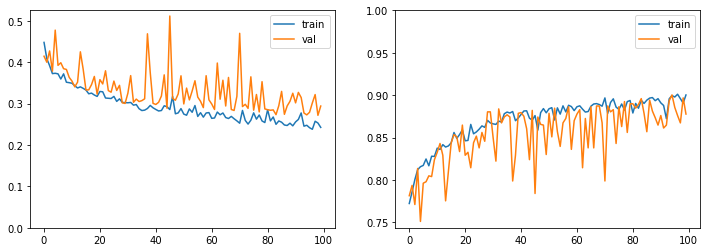

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5990 - accuracy: 0.6514 - precision: 0.7333 - recall: 0.6299 - f1: 0.6489 - specificity: 0.6608 - negative_predictive_value: 0.5792 - matthews_correlation_coefficient: 0.3108 - val_loss: 0.5513 - val_accuracy: 0.7016 - val_precision: 0.7710 - val_recall: 0.6314 - val_f1: 0.6867 - val_specificity: 0.7846 - val_negative_predictive_value: 0.6274 - val_matthews_correlation_coefficient: 0.4061

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.40611, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_25-01_03_52.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5757 - accuracy: 0.6774 - precision: 0.7595 - recall: 0.6523 - f1: 0.6863 - specificity: 0.7111 - negative_predictive_value: 0.6165 - matthews_correlation_coefficient: 0.3708 - val_loss: 0.5567 - val_accuracy: 0.6869 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5104 - accuracy: 0.7414 - precision: 0.8089 - recall: 0.7327 - f1: 0.7595 - specificity: 0.7558 - negative_predictive_value: 0.6820 - matthews_correlation_coefficient: 0.4892 - val_loss: 0.4945 - val_accuracy: 0.7459 - val_precision: 0.7400 - val_recall: 0.7893 - val_f1: 0.7587 - val_specificity: 0.6735 - val_negative_predictive_value: 0.7193 - val_matthews_correlation_coefficient: 0.4603

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.48563
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5106 - accuracy: 0.7406 - precision: 0.8023 - recall: 0.7301 - f1: 0.7544 - specificity: 0.7610 - negative_predictive_value: 0.6831 - matthews_correlation_coefficient: 0.4895 - val_loss: 0.4845 - val_accuracy: 0.7580 - val_precision: 0.7551 - val_recall: 0.7842 - val_f1: 0.7643 - val_specificity: 0.7047 - val_negative_predictive_value: 0.7284 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient improved from 0.50966 to 0.51997, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_25-01_03_52.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4730 - accuracy: 0.7655 - precision: 0.8262 - recall: 0.7594 - f1: 0.7841 - specificity: 0.7848 - negative_predictive_value: 0.7070 - matthews_correlation_coefficient: 0.5380 - val_loss: 0.4719 - val_accuracy: 0.7641 - val_precision: 0.7412 - val_recall: 0.8216 - val_f1: 0.7752 - val_specificity: 0.6676 - val_negative_predictive_value: 0.7623 - val_matthews_correlation_coefficient: 0.4958

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.51997
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4649 - accuracy: 0.7759 - precision: 0.8276 - recall: 0.7849 - f1: 0.7985 - specificity: 0.7718 - negative_predictive_value: 0.7262 - matthews_correlation_coefficient: 0.5547 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4527 - accuracy: 0.7872 - precision: 0.8287 - recall: 0.7900 - f1: 0.8015 - specificity: 0.7823 - negative_predictive_value: 0.7402 - matthews_correlation_coefficient: 0.5717 - val_loss: 0.5021 - val_accuracy: 0.7615 - val_precision: 0.8569 - val_recall: 0.6574 - val_f1: 0.7359 - val_specificity: 0.8845 - val_negative_predictive_value: 0.6740 - val_matthews_correlation_coefficient: 0.5352

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.55238
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4580 - accuracy: 0.7742 - precision: 0.8245 - recall: 0.7631 - f1: 0.7854 - specificity: 0.7842 - negative_predictive_value: 0.7119 - matthews_correlation_coefficient: 0.5429 - val_loss: 0.4554 - val_accuracy: 0.7728 - val_precision: 0.7942 - val_recall: 0.7539 - val_f1: 0.7675 - val_specificity: 0.7799 - val_negative_predictive_value: 0.7218 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.56227
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4428 - accuracy: 0.7915 - precision: 0.8483 - recall: 0.7816 - f1: 0.8053 - specificity: 0.7970 - negative_predictive_value: 0.7343 - matthews_correlation_coefficient: 0.5816 - val_loss: 0.4534 - val_accuracy: 0.7754 - val_precision: 0.7794 - val_recall: 0.7783 - val_f1: 0.7743 - val_specificity: 0.7516 - val_negative_predictive_value: 0.7371 - val_matthews_correlation_coefficient: 0.5226

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.56227
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4423 - accuracy: 0.7957 - precision: 0.8365 - recall: 0.7932 - f1: 0.8089 - specificity: 0.7942 - negative_predictive_value: 0.7429 - matthews_correlation_coefficient: 0.5847 - val_loss: 0.4829 - val_accuracy: 0.7684 - val_precision: 0.8412 - val_recall: 0.6857 - val_f1: 0.7486 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.56906
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4271 - accuracy: 0.7978 - precision: 0.8558 - recall: 0.7873 - f1: 0.8126 - specificity: 0.8126 - negative_predictive_value: 0.7519 - matthews_correlation_coefficient: 0.6030 - val_loss: 0.4455 - val_accuracy: 0.7849 - val_precision: 0.7496 - val_recall: 0.8606 - val_f1: 0.7968 - val_specificity: 0.6632 - val_negative_predictive_value: 0.8064 - val_matthews_correlation_coefficient: 0.5389

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.56906
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4251 - accuracy: 0.7948 - precision: 0.8449 - recall: 0.7805 - f1: 0.8061 - specificity: 0.8024 - negative_predictive_value: 0.7317 - matthews_correlation_coefficient: 0.5863 - val_loss: 0.4580 - val_accuracy: 0.7892 - val_precision: 0.7560 - val_recall: 0.8592 - val_f1: 0.7997 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.56906
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4173 - accuracy: 0.8037 - precision: 0.8462 - recall: 0.7945 - f1: 0.8141 - specificity: 0.8063 - negative_predictive_value: 0.7472 - matthews_correlation_coefficient: 0.5966 - val_loss: 0.4453 - val_accuracy: 0.7918 - val_precision: 0.7835 - val_recall: 0.8149 - val_f1: 0.7939 - val_specificity: 0.7417 - val_negative_predictive_value: 0.7699 - val_matthews_correlation_coefficient: 0.5543

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.56906
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4188 - accuracy: 0.8043 - precision: 0.8489 - recall: 0.7936 - f1: 0.8146 - specificity: 0.8101 - negative_predictive_value: 0.7550 - matthews_correlation_coefficient: 0.6052 - val_loss: 0.4675 - val_accuracy: 0.7832 - val_precision: 0.7975 - val_recall: 0.7699 - val_f1: 0.7789 - val_spe

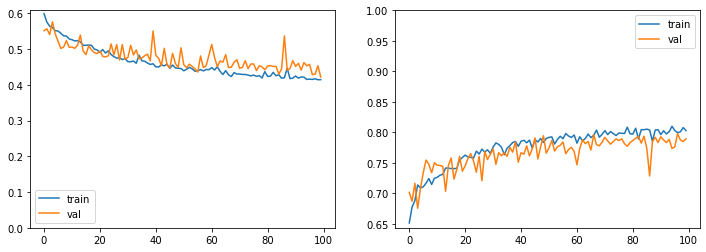

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5795 - accuracy: 0.5317 - precision: 0.9656 - recall: 0.4949 - f1: 0.6481 - specificity: 0.8624 - negative_predictive_value: 0.1794 - matthews_correlation_coefficient: 0.2240 - val_loss: 0.6738 - val_accuracy: 0.4588 - val_precision: 0.9535 - val_recall: 0.3885 - val_f1: 0.5466 - val_specificity: 0.9039 - val_negative_predictive_value: 0.1567 - val_matthews_correlation_coefficient: 0.2071

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20707, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_25-01_18_40.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5580 - accuracy: 0.5555 - precision: 0.9676 - recall: 0.5196 - f1: 0.6648 - specificity: 0.8199 - negative_predictive_value: 0.1916 - matthews_correlation_coefficient: 0.2293 - val_loss: 0.5803 - val_accuracy: 0.4918 - val_pre

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4724 - accuracy: 0.6965 - precision: 0.9706 - recall: 0.6845 - f1: 0.7945 - specificity: 0.7903 - negative_predictive_value: 0.2587 - matthews_correlation_coefficient: 0.3285 - val_loss: 0.6123 - val_accuracy: 0.5785 - val_precision: 0.9483 - val_recall: 0.5255 - val_f1: 0.6690 - val_specificity: 0.8791 - val_negative_predictive_value: 0.2147 - val_matthews_correlation_coefficient: 0.2525

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.30967
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4609 - accuracy: 0.7143 - precision: 0.9742 - recall: 0.7027 - f1: 0.8085 - specificity: 0.8332 - negative_predictive_value: 0.2729 - matthews_correlation_coefficient: 0.3552 - val_loss: 0.5426 - val_accuracy: 0.6548 - val_precision: 0.9511 - val_recall: 0.6085 - val_f1: 0.7390 - val_specificity: 0.8946 - val_negative_predictive_value: 0.2507 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4080 - accuracy: 0.7720 - precision: 0.9761 - recall: 0.7666 - f1: 0.8495 - specificity: 0.8158 - negative_predictive_value: 0.3407 - matthews_correlation_coefficient: 0.4169 - val_loss: 0.5295 - val_accuracy: 0.6791 - val_precision: 0.9659 - val_recall: 0.6268 - val_f1: 0.7569 - val_specificity: 0.9458 - val_negative_predictive_value: 0.2701 - val_matthews_correlation_coefficient: 0.3606

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.41030
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3943 - accuracy: 0.7681 - precision: 0.9772 - recall: 0.7570 - f1: 0.8477 - specificity: 0.8369 - negative_predictive_value: 0.3197 - matthews_correlation_coefficient: 0.4119 - val_loss: 0.2601 - val_accuracy: 0.8951 - val_precision: 0.9319 - val_recall: 0.8966 - val_f1: 0.9131 - val_specificity: 0.6879 - val_negative_predictive_value: 0.5330 - val_matthews_correlation_coefficie


Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3550 - accuracy: 0.7998 - precision: 0.9807 - recall: 0.7894 - f1: 0.8688 - specificity: 0.8395 - negative_predictive_value: 0.3722 - matthews_correlation_coefficient: 0.4620 - val_loss: 0.4248 - val_accuracy: 0.7407 - val_precision: 0.9654 - val_recall: 0.6955 - val_f1: 0.8059 - val_specificity: 0.9299 - val_negative_predictive_value: 0.3119 - val_matthews_correlation_coefficient: 0.4084

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3808 - accuracy: 0.7924 - precision: 0.9823 - recall: 0.7824 - f1: 0.8634 - specificity: 0.8533 - negative_predictive_value: 0.3646 - matthews_correlation_coefficient: 0.4599 - val_loss: 0.4690 - val_accuracy: 0.7320 - val_precision: 0.9660 - val_recall: 0.6852 - val_f1: 0.7984 - val_spe


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3620 - accuracy: 0.7874 - precision: 0.9817 - recall: 0.7787 - f1: 0.8613 - specificity: 0.8381 - negative_predictive_value: 0.3641 - matthews_correlation_coefficient: 0.4541 - val_loss: 0.6491 - val_accuracy: 0.6513 - val_precision: 0.9685 - val_recall: 0.5947 - val_f1: 0.7329 - val_specificity: 0.9518 - val_negative_predictive_value: 0.2572 - val_matthews_correlation_coefficient: 0.3444

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3352 - accuracy: 0.8111 - precision: 0.9812 - recall: 0.8014 - f1: 0.8779 - specificity: 0.8647 - negative_predictive_value: 0.3753 - matthews_correlation_coefficient: 0.4784 - val_loss: 0.5923 - val_accuracy: 0.6635 - val_precision: 0.9687 - val_recall: 0.6073 - val_f1: 0.7425 - val_spe

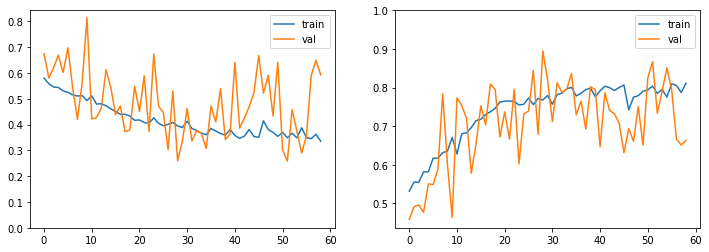

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5822 - accuracy: 0.6709 - precision: 0.9109 - recall: 0.6548 - f1: 0.7552 - specificity: 0.7441 - negative_predictive_value: 0.3498 - matthews_correlation_coefficient: 0.3194 - val_loss: 0.5914 - val_accuracy: 0.7095 - val_precision: 0.8686 - val_recall: 0.7062 - val_f1: 0.7758 - val_specificity: 0.6629 - val_negative_predictive_value: 0.3870 - val_matthews_correlation_coefficient: 0.3046

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30461, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_25-01_27_34.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5676 - accuracy: 0.7087 - precision: 0.9073 - recall: 0.7107 - f1: 0.7928 - specificity: 0.6996 - negative_predictive_value: 0.3765 - matthews_correlation_coefficient: 0.3393 - val_loss: 0.5929 - val_accuracy: 0.6938 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36109
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5184 - accuracy: 0.7130 - precision: 0.9225 - recall: 0.7063 - f1: 0.7949 - specificity: 0.7574 - negative_predictive_value: 0.3915 - matthews_correlation_coefficient: 0.3770 - val_loss: 0.5293 - val_accuracy: 0.6678 - val_precision: 0.9157 - val_recall: 0.6060 - val_f1: 0.7264 - val_specificity: 0.8538 - val_negative_predictive_value: 0.3715 - val_matthews_correlation_coefficient: 0.3606

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36109
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5195 - accuracy: 0.7269 - precision: 0.9225 - recall: 0.7255 - f1: 0.8057 - specificity: 0.7602 - negative_predictive_value: 0.4105 - matthews_correlation_coefficient: 0.3973 - val_loss: 0.5976 - val_accuracy: 0.6479 - val_precision: 0.9176 - val_recall: 0.5808 - val_f1: 0.7078 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4978 - accuracy: 0.7254 - precision: 0.9288 - recall: 0.7176 - f1: 0.8016 - specificity: 0.7534 - negative_predictive_value: 0.4112 - matthews_correlation_coefficient: 0.3965 - val_loss: 0.4769 - val_accuracy: 0.7441 - val_precision: 0.9000 - val_recall: 0.7210 - val_f1: 0.7972 - val_specificity: 0.7631 - val_negative_predictive_value: 0.4334 - val_matthews_correlation_coefficient: 0.3987

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40850
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4942 - accuracy: 0.7371 - precision: 0.9253 - recall: 0.7379 - f1: 0.8149 - specificity: 0.7381 - negative_predictive_value: 0.4214 - matthews_correlation_coefficient: 0.4013 - val_loss: 0.5912 - val_accuracy: 0.6843 - val_precision: 0.9143 - val_recall: 0.6315 - val_f1: 0.7434 - val_specificity: 0.8402 - val_negative_predictive_value: 0.3843 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4712 - accuracy: 0.7534 - precision: 0.9335 - recall: 0.7451 - f1: 0.8226 - specificity: 0.7588 - negative_predictive_value: 0.4448 - matthews_correlation_coefficient: 0.4350 - val_loss: 0.4191 - val_accuracy: 0.8101 - val_precision: 0.8927 - val_recall: 0.8157 - val_f1: 0.8504 - val_specificity: 0.7013 - val_negative_predictive_value: 0.5253 - val_matthews_correlation_coefficient: 0.4615

Epoch 00044: val_matthews_correlation_coefficient improved from 0.40850 to 0.46152, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_25-01_27_34.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4761 - accuracy: 0.7612 - precision: 0.9301 - recall: 0.7649 - f1: 0.8335 - specificity: 0.7749 - negative_predictive_value: 0.4646 - matthews_correlation_coefficient: 0.4556 - val_loss: 0.6238 - val_accuracy: 0.6435 - val_precision: 0.9323 - val_recall: 0.5646 - val_f1: 0.


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.46152
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4512 - accuracy: 0.7659 - precision: 0.9399 - recall: 0.7567 - f1: 0.8320 - specificity: 0.7945 - negative_predictive_value: 0.4652 - matthews_correlation_coefficient: 0.4699 - val_loss: 0.4974 - val_accuracy: 0.7086 - val_precision: 0.9137 - val_recall: 0.6605 - val_f1: 0.7635 - val_specificity: 0.8340 - val_negative_predictive_value: 0.4084 - val_matthews_correlation_coefficient: 0.3966

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.46152
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4672 - accuracy: 0.7629 - precision: 0.9243 - recall: 0.7614 - f1: 0.8270 - specificity: 0.7556 - negative_predictive_value: 0.4685 - matthews_correlation_coefficient: 0.4511 - val_loss: 0.8581 - val_accuracy: 0.6071 - val_precision: 0.9357 - val_recall: 0.5151 - val_f1: 0.6605 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46152
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4504 - accuracy: 0.7716 - precision: 0.9346 - recall: 0.7744 - f1: 0.8405 - specificity: 0.7677 - negative_predictive_value: 0.4722 - matthews_correlation_coefficient: 0.4629 - val_loss: 0.6739 - val_accuracy: 0.6236 - val_precision: 0.9376 - val_recall: 0.5351 - val_f1: 0.6767 - val_specificity: 0.9303 - val_negative_predictive_value: 0.3544 - val_matthews_correlation_coefficient: 0.3656
Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.46152
Epoch 00074: early stopping

   Final Accuracy:  81.01%
  Final Precision:  91.71%
     Final Recall:  83.86%
  Final F-measure:  87.61%
Final Specificity:  69.57%
        Final NPV:  51.78%
        Final MCC:  48.20%
[[160  70]
 [149 774]]
              precision    recall  f1-score   support

           0     

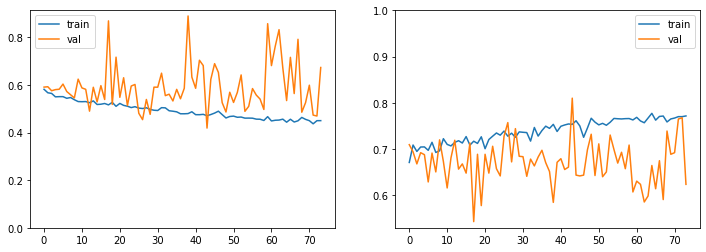

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5681 - accuracy: 0.8458 - precision: 0.9984 - recall: 0.8478 - f1: 0.9088 - specificity: 0.0621 - negative_predictive_value: 0.0149 - matthews_correlation_coefficient: 0.0238 - val_loss: 0.0466 - val_accuracy: 0.9965 - val_precision: 0.9966 - val_recall: 1.0000 - val_f1: 0.9983 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00000, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_25-01_38_37.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5937 - accuracy: 0.6807 - precision: 0.9989 - recall: 0.6831 - f1: 0.7893 - specificity: 0.0759 - negative_predictive_value: 0.0139 - matthews_correlation_coefficient: 0.0235 - val_loss: 0.3448 - val_accuracy: 0.8023


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.05577
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2612 - accuracy: 0.8393 - precision: 0.9998 - recall: 0.8369 - f1: 0.9079 - specificity: 0.0931 - negative_predictive_value: 0.0348 - matthews_correlation_coefficient: 0.0498 - val_loss: 0.2228 - val_accuracy: 0.8907 - val_precision: 1.0000 - val_recall: 0.8932 - val_f1: 0.9425 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0279 - val_matthews_correlation_coefficient: 0.0503

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.05577
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2145 - accuracy: 0.8731 - precision: 0.9998 - recall: 0.8704 - f1: 0.9278 - specificity: 0.1034 - negative_predictive_value: 0.0256 - matthews_correlation_coefficient: 0.0462 - val_loss: 0.3217 - val_accuracy: 0.8352 - val_precision: 1.0000 - val_recall: 0.8389 - val_f1: 0.9106 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1553 - accuracy: 0.9347 - precision: 0.9998 - recall: 0.9351 - f1: 0.9654 - specificity: 0.1034 - negative_predictive_value: 0.0375 - matthews_correlation_coefficient: 0.0580 - val_loss: 0.4785 - val_accuracy: 0.8300 - val_precision: 1.0000 - val_recall: 0.8339 - val_f1: 0.9077 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0197 - val_matthews_correlation_coefficient: 0.0412

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.08343
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1878 - accuracy: 0.8824 - precision: 1.0000 - recall: 0.8829 - f1: 0.9361 - specificity: 0.1034 - negative_predictive_value: 0.0355 - matthews_correlation_coefficient: 0.0563 - val_loss: 0.1204 - val_accuracy: 0.9428 - val_precision: 1.0000 - val_recall: 0.9441 - val_f1: 0.9706 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0631 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1703 - accuracy: 0.9106 - precision: 0.9998 - recall: 0.9111 - f1: 0.9522 - specificity: 0.1000 - negative_predictive_value: 0.0313 - matthews_correlation_coefficient: 0.0521 - val_loss: 0.1207 - val_accuracy: 0.9488 - val_precision: 1.0000 - val_recall: 0.9501 - val_f1: 0.9737 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0766 - val_matthews_correlation_coefficient: 0.0879

Epoch 00044: val_matthews_correlation_coefficient improved from 0.08343 to 0.08795, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_25-01_38_37.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1399 - accuracy: 0.9217 - precision: 1.0000 - recall: 0.9219 - f1: 0.9585 - specificity: 0.1103 - negative_predictive_value: 0.0507 - matthews_correlation_coefficient: 0.0686 - val_loss: 0.1049 - val_accuracy: 0.9514 - val_precision: 1.0000 - val_recall: 0.9526 - val_f1: 0.9752 - val


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.09165
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2474 - accuracy: 0.9410 - precision: 0.9998 - recall: 0.9414 - f1: 0.9689 - specificity: 0.1034 - negative_predictive_value: 0.0490 - matthews_correlation_coefficient: 0.0672 - val_loss: 0.4268 - val_accuracy: 0.8517 - val_precision: 1.0000 - val_recall: 0.8551 - val_f1: 0.9206 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0234 - val_matthews_correlation_coefficient: 0.0466

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.09165
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1409 - accuracy: 0.9054 - precision: 1.0000 - recall: 0.9056 - f1: 0.9495 - specificity: 0.1103 - negative_predictive_value: 0.0325 - matthews_correlation_coefficient: 0.0545 - val_loss: 0.1799 - val_accuracy: 0.9141 - val_precision: 1.0000 - val_recall: 0.9161 - val_f1: 0.9554 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.09165
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0634 - accuracy: 0.9655 - precision: 1.0000 - recall: 0.9656 - f1: 0.9823 - specificity: 0.1034 - negative_predictive_value: 0.0598 - matthews_correlation_coefficient: 0.0754 - val_loss: 0.0390 - val_accuracy: 0.9792 - val_precision: 0.9992 - val_recall: 0.9805 - val_f1: 0.9895 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0405 - val_matthews_correlation_coefficient: 0.0564

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.09165
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1150 - accuracy: 0.9406 - precision: 1.0000 - recall: 0.9408 - f1: 0.9690 - specificity: 0.1103 - negative_predictive_value: 0.0652 - matthews_correlation_coefficient: 0.0810 - val_loss: 0.1500 - val_accuracy: 0.9350 - val_precision: 1.0000 - val_recall: 0.9365 - val_f1: 0.9665 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1031 - accuracy: 0.9456 - precision: 1.0000 - recall: 0.9457 - f1: 0.9714 - specificity: 0.1034 - negative_predictive_value: 0.0464 - matthews_correlation_coefficient: 0.0650 - val_loss: 0.0224 - val_accuracy: 0.9922 - val_precision: 0.9992 - val_recall: 0.9932 - val_f1: 0.9961 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0676 - val_matthews_correlation_coefficient: 0.0729

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0642 - accuracy: 0.9670 - precision: 1.0000 - recall: 0.9672 - f1: 0.9830 - specificity: 0.1103 - negative_predictive_value: 0.0816 - matthews_correlation_coefficient: 0.0917 - val_loss: 0.0434 - val_accuracy: 0.9801 - val_precision: 1.0000 - val_recall: 0.9805 - val_f1: 0.9900 - val_spe

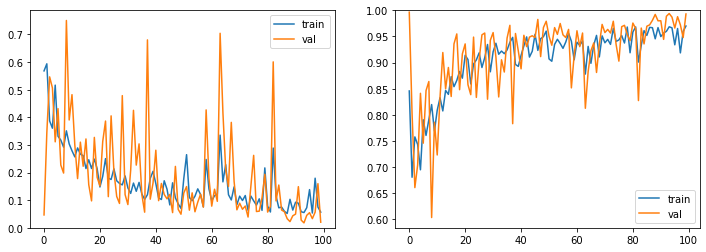

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6063 - accuracy: 0.6195 - precision: 0.8787 - recall: 0.5539 - f1: 0.6685 - specificity: 0.7882 - negative_predictive_value: 0.4126 - matthews_correlation_coefficient: 0.3157 - val_loss: 0.6500 - val_accuracy: 0.6002 - val_precision: 0.8877 - val_recall: 0.4816 - val_f1: 0.6178 - val_specificity: 0.8740 - val_negative_predictive_value: 0.4166 - val_matthews_correlation_coefficient: 0.3269

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.32688, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_25-01_53_28.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5936 - accuracy: 0.6304 - precision: 0.8742 - recall: 0.5703 - f1: 0.6789 - specificity: 0.7913 - negative_predictive_value: 0.4224 - matthews_correlation_coefficient: 0.3256 - val_loss: 0.6527 - val_accuracy: 0.5325 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5476 - accuracy: 0.6816 - precision: 0.9021 - recall: 0.6293 - f1: 0.7348 - specificity: 0.8218 - negative_predictive_value: 0.4650 - matthews_correlation_coefficient: 0.4053 - val_loss: 0.5143 - val_accuracy: 0.6834 - val_precision: 0.8054 - val_recall: 0.6898 - val_f1: 0.7372 - val_specificity: 0.6266 - val_negative_predictive_value: 0.4685 - val_matthews_correlation_coefficient: 0.2933

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.40643
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5480 - accuracy: 0.6863 - precision: 0.9112 - recall: 0.6363 - f1: 0.7412 - specificity: 0.8310 - negative_predictive_value: 0.4692 - matthews_correlation_coefficient: 0.4197 - val_loss: 0.4894 - val_accuracy: 0.7216 - val_precision: 0.7933 - val_recall: 0.7698 - val_f1: 0.7773 - val_specificity: 0.5528 - val_negative_predictive_value: 0.5252 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42949
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5106 - accuracy: 0.7033 - precision: 0.9176 - recall: 0.6489 - f1: 0.7543 - specificity: 0.8545 - negative_predictive_value: 0.4912 - matthews_correlation_coefficient: 0.4520 - val_loss: 0.5703 - val_accuracy: 0.6765 - val_precision: 0.8959 - val_recall: 0.5860 - val_f1: 0.7036 - val_specificity: 0.8734 - val_negative_predictive_value: 0.4747 - val_matthews_correlation_coefficient: 0.4108

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.42949
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5120 - accuracy: 0.7121 - precision: 0.9229 - recall: 0.6604 - f1: 0.7636 - specificity: 0.8553 - negative_predictive_value: 0.4954 - matthews_correlation_coefficient: 0.4622 - val_loss: 0.4899 - val_accuracy: 0.7112 - val_precision: 0.8450 - val_recall: 0.6861 - val_f1: 0.7531 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43752
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4868 - accuracy: 0.7254 - precision: 0.9161 - recall: 0.6709 - f1: 0.7692 - specificity: 0.8583 - negative_predictive_value: 0.5084 - matthews_correlation_coefficient: 0.4787 - val_loss: 0.5315 - val_accuracy: 0.7016 - val_precision: 0.8823 - val_recall: 0.6365 - val_f1: 0.7346 - val_specificity: 0.8196 - val_negative_predictive_value: 0.4948 - val_matthews_correlation_coefficient: 0.4131

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.43752
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4974 - accuracy: 0.7243 - precision: 0.9176 - recall: 0.6732 - f1: 0.7706 - specificity: 0.8498 - negative_predictive_value: 0.5063 - matthews_correlation_coefficient: 0.4689 - val_loss: 0.6490 - val_accuracy: 0.6713 - val_precision: 0.9199 - val_recall: 0.5625 - val_f1: 0.6922 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4829 - accuracy: 0.7308 - precision: 0.9226 - recall: 0.6891 - f1: 0.7830 - specificity: 0.8500 - negative_predictive_value: 0.5155 - matthews_correlation_coefficient: 0.4833 - val_loss: 0.5248 - val_accuracy: 0.7042 - val_precision: 0.9038 - val_recall: 0.6235 - val_f1: 0.7316 - val_specificity: 0.8739 - val_negative_predictive_value: 0.5003 - val_matthews_correlation_coefficient: 0.4462

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45601
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4867 - accuracy: 0.7234 - precision: 0.9220 - recall: 0.6775 - f1: 0.7735 - specificity: 0.8566 - negative_predictive_value: 0.5136 - matthews_correlation_coefficient: 0.4798 - val_loss: 0.6657 - val_accuracy: 0.6427 - val_precision: 0.9107 - val_recall: 0.5279 - val_f1: 0.6631 - val_specificity: 0.9070 - val_negative_predictive_value: 0.4506 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.47147
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4652 - accuracy: 0.7347 - precision: 0.9303 - recall: 0.6856 - f1: 0.7841 - specificity: 0.8612 - negative_predictive_value: 0.5196 - matthews_correlation_coefficient: 0.4943 - val_loss: 0.5555 - val_accuracy: 0.6973 - val_precision: 0.9098 - val_recall: 0.6072 - val_f1: 0.7215 - val_specificity: 0.8905 - val_negative_predictive_value: 0.4964 - val_matthews_correlation_coefficient: 0.4475

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.47147
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4664 - accuracy: 0.7384 - precision: 0.9225 - recall: 0.6965 - f1: 0.7890 - specificity: 0.8503 - negative_predictive_value: 0.5221 - matthews_correlation_coefficient: 0.4910 - val_loss: 0.5240 - val_accuracy: 0.7225 - val_precision: 0.8930 - val_recall: 0.6593 - val_f1: 0.7529 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.47147
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4714 - accuracy: 0.7362 - precision: 0.9272 - recall: 0.6918 - f1: 0.7851 - specificity: 0.8578 - negative_predictive_value: 0.5236 - matthews_correlation_coefficient: 0.4954 - val_loss: 0.5069 - val_accuracy: 0.7268 - val_precision: 0.8784 - val_recall: 0.6779 - val_f1: 0.7612 - val_specificity: 0.7986 - val_negative_predictive_value: 0.5180 - val_matthews_correlation_coefficient: 0.4331

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.47147
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4528 - accuracy: 0.7547 - precision: 0.9254 - recall: 0.7162 - f1: 0.8027 - specificity: 0.8433 - negative_predictive_value: 0.5409 - matthews_correlation_coefficient: 0.5106 - val_loss: 0.5720 - val_accuracy: 0.6878 - val_precision: 0.8745 - val_recall: 0.6183 - val_f1: 0.7208 - val_spe

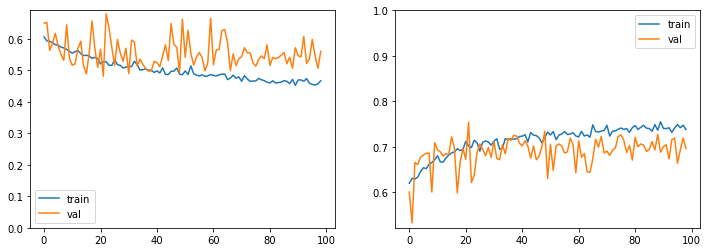

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5974 - accuracy: 0.6104 - precision: 0.9315 - recall: 0.5952 - f1: 0.7072 - specificity: 0.7167 - negative_predictive_value: 0.2416 - matthews_correlation_coefficient: 0.2278 - val_loss: 0.4298 - val_accuracy: 0.8101 - val_precision: 0.8861 - val_recall: 0.9004 - val_f1: 0.8912 - val_specificity: 0.2746 - val_negative_predictive_value: 0.3029 - val_matthews_correlation_coefficient: 0.1771

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.17711, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_25-02_08_21.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5629 - accuracy: 0.6230 - precision: 0.9442 - recall: 0.6035 - f1: 0.7222 - specificity: 0.7505 - negative_predictive_value: 0.2576 - matthews_correlation_coefficient: 0.2673 - val_loss: 0.4805 - val_accuracy: 0.7042 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.39430
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4969 - accuracy: 0.6998 - precision: 0.9548 - recall: 0.6878 - f1: 0.7882 - specificity: 0.7700 - negative_predictive_value: 0.3116 - matthews_correlation_coefficient: 0.3444 - val_loss: 0.3917 - val_accuracy: 0.8023 - val_precision: 0.9417 - val_recall: 0.8275 - val_f1: 0.8789 - val_specificity: 0.6421 - val_negative_predictive_value: 0.3734 - val_matthews_correlation_coefficient: 0.3798

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39430
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4757 - accuracy: 0.7184 - precision: 0.9545 - recall: 0.7070 - f1: 0.8054 - specificity: 0.8015 - negative_predictive_value: 0.3263 - matthews_correlation_coefficient: 0.3766 - val_loss: 0.4217 - val_accuracy: 0.7745 - val_precision: 0.9511 - val_recall: 0.7832 - val_f1: 0.8565 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4455 - accuracy: 0.7469 - precision: 0.9615 - recall: 0.7321 - f1: 0.8262 - specificity: 0.8166 - negative_predictive_value: 0.3488 - matthews_correlation_coefficient: 0.4069 - val_loss: 0.4319 - val_accuracy: 0.7745 - val_precision: 0.9611 - val_recall: 0.7751 - val_f1: 0.8555 - val_specificity: 0.7833 - val_negative_predictive_value: 0.3607 - val_matthews_correlation_coefficient: 0.4169

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43285
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4436 - accuracy: 0.7469 - precision: 0.9604 - recall: 0.7380 - f1: 0.8298 - specificity: 0.7858 - negative_predictive_value: 0.3503 - matthews_correlation_coefficient: 0.3992 - val_loss: 0.3350 - val_accuracy: 0.8474 - val_precision: 0.9347 - val_recall: 0.8895 - val_f1: 0.9100 - val_specificity: 0.6060 - val_negative_predictive_value: 0.4432 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.44954
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3983 - accuracy: 0.7866 - precision: 0.9662 - recall: 0.7798 - f1: 0.8577 - specificity: 0.8384 - negative_predictive_value: 0.4045 - matthews_correlation_coefficient: 0.4697 - val_loss: 0.3442 - val_accuracy: 0.8213 - val_precision: 0.9342 - val_recall: 0.8590 - val_f1: 0.8931 - val_specificity: 0.6113 - val_negative_predictive_value: 0.3857 - val_matthews_correlation_coefficient: 0.3803

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44954
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4096 - accuracy: 0.7748 - precision: 0.9650 - recall: 0.7671 - f1: 0.8508 - specificity: 0.8337 - negative_predictive_value: 0.3829 - matthews_correlation_coefficient: 0.4495 - val_loss: 0.3559 - val_accuracy: 0.8395 - val_precision: 0.9411 - val_recall: 0.8732 - val_f1: 0.9043 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3906 - accuracy: 0.7885 - precision: 0.9655 - recall: 0.7816 - f1: 0.8592 - specificity: 0.8373 - negative_predictive_value: 0.4012 - matthews_correlation_coefficient: 0.4703 - val_loss: 0.3245 - val_accuracy: 0.8404 - val_precision: 0.9386 - val_recall: 0.8767 - val_f1: 0.9050 - val_specificity: 0.6332 - val_negative_predictive_value: 0.4458 - val_matthews_correlation_coefficient: 0.4344

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.50025
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4611 - accuracy: 0.7538 - precision: 0.9620 - recall: 0.7470 - f1: 0.8333 - specificity: 0.8066 - negative_predictive_value: 0.3675 - matthews_correlation_coefficient: 0.4208 - val_loss: 0.3136 - val_accuracy: 0.8474 - val_precision: 0.9428 - val_recall: 0.8789 - val_f1: 0.9083 - val_specificity: 0.6513 - val_negative_predictive_value: 0.4613 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient improved from 0.50869 to 0.50969, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_25-02_08_21.h5
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3812 - accuracy: 0.7985 - precision: 0.9616 - recall: 0.7873 - f1: 0.8617 - specificity: 0.8328 - negative_predictive_value: 0.4164 - matthews_correlation_coefficient: 0.4831 - val_loss: 0.3479 - val_accuracy: 0.8422 - val_precision: 0.9615 - val_recall: 0.8554 - val_f1: 0.9034 - val_specificity: 0.7640 - val_negative_predictive_value: 0.4704 - val_matthews_correlation_coefficient: 0.5082

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.50969
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4446 - accuracy: 0.7553 - precision: 0.9622 - recall: 0.7426 - f1: 0.8257 - specificity: 0.8023 - negative_predictive_value: 0.3800 - matthews_correlation_coefficient: 0.4253 - val_loss: 0.3404 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3677 - accuracy: 0.8132 - precision: 0.9679 - recall: 0.8115 - f1: 0.8793 - specificity: 0.8343 - negative_predictive_value: 0.4383 - matthews_correlation_coefficient: 0.5022 - val_loss: 0.2911 - val_accuracy: 0.8630 - val_precision: 0.9441 - val_recall: 0.8989 - val_f1: 0.9198 - val_specificity: 0.6513 - val_negative_predictive_value: 0.4762 - val_matthews_correlation_coefficient: 0.4732

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.51652
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3609 - accuracy: 0.8174 - precision: 0.9674 - recall: 0.8175 - f1: 0.8822 - specificity: 0.8300 - negative_predictive_value: 0.4485 - matthews_correlation_coefficient: 0.5097 - val_loss: 0.3153 - val_accuracy: 0.8465 - val_precision: 0.9400 - val_recall: 0.8823 - val_f1: 0.9086 - val_specificity: 0.6121 - val_negative_predictive_value: 0.4455 - val_matthews_correlation_coefficie

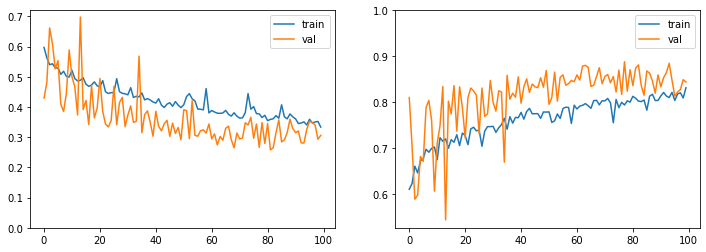

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_25-02_23_20.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9158 - precision: 0.9932 - recall: 0.9173 - f1: 0.9524 - specificity: 0.8023 - negative_predictive_value: 0.4604 - matthews_correlation_coefficient: 0.5620 - val_loss: 0.1886 - val_accuracy: 0.9376 - val_precision: 0.9635 - val_recall: 0.9180 - val_f1: 0.9398 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: 0.5381

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.9197 - precision: 0.9918 - recall: 0.9224 - f1: 0.9549 - specificity: 0.7823 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.5401 - val_loss: 0.2038 - val_accuracy: 0.9384 - val_precision: 0.9635 - val_recall: 0.9189 - val_f1: 0.9402 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2005 - accuracy: 0.9386 - precision: 0.9939 - recall: 0.9377 - f1: 0.9638 - specificity: 0.7611 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.1303 - val_accuracy: 0.9636 - val_precision: 0.9908 - val_recall: 0.9710 - val_f1: 0.9805 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5948 - val_matthews_correlation_coefficient: 0.6447

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59848 to 0.64469, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_25-02_23_20.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2301 - accuracy: 0.9278 - precision: 0.9891 - recall: 0.9306 - f1: 0.9568 - specificity: 0.7816 - negative_predictive_value: 0.4989 - matthews_correlation_coefficient: 0.5805 - val_loss: 0.3644 - val_accuracy: 0.8942 - val_precision: 0.9669 - val_recall: 0.8696 - val_f1: 0.9149 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64469
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1746 - accuracy: 0.9403 - precision: 0.9942 - recall: 0.9425 - f1: 0.9666 - specificity: 0.7902 - negative_predictive_value: 0.5440 - matthews_correlation_coefficient: 0.6154 - val_loss: 0.1422 - val_accuracy: 0.9575 - val_precision: 0.9673 - val_recall: 0.9352 - val_f1: 0.9506 - val_specificity: 0.8063 - val_negative_predictive_value: 0.6011 - val_matthews_correlation_coefficient: 0.6642

Epoch 00044: val_matthews_correlation_coefficient improved from 0.64469 to 0.66424, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_25-02_23_20.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1627 - accuracy: 0.9538 - precision: 0.9942 - recall: 0.9566 - f1: 0.9745 - specificity: 0.8156 - negative_predictive_value: 0.5999 - matthews_correlation_coefficient: 0.6658 - val_loss: 0.2724

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1434 - accuracy: 0.9544 - precision: 0.9951 - recall: 0.9569 - f1: 0.9749 - specificity: 0.7929 - negative_predictive_value: 0.6069 - matthews_correlation_coefficient: 0.6603 - val_loss: 0.3438 - val_accuracy: 0.8907 - val_precision: 0.9700 - val_recall: 0.8630 - val_f1: 0.9128 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.4800

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1640 - accuracy: 0.9471 - precision: 0.9953 - recall: 0.9483 - f1: 0.9700 - specificity: 0.8495 - negative_predictive_value: 0.5979 - matthews_correlation_coefficient: 0.6767 - val_loss: 0.4156 - val_accuracy: 0.8716 - val_precision: 0.9688 - val_recall: 0.8444 - val_f1: 0.9017 - val_specificity: 0.8266 - val_negative_predictive_value: 0.2989 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1380 - accuracy: 0.9555 - precision: 0.9955 - recall: 0.9576 - f1: 0.9757 - specificity: 0.8283 - negative_predictive_value: 0.5924 - matthews_correlation_coefficient: 0.6659 - val_loss: 0.2782 - val_accuracy: 0.8699 - val_precision: 0.9698 - val_recall: 0.8411 - val_f1: 0.9001 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3008 - val_matthews_correlation_coefficient: 0.4507

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1275 - accuracy: 0.9586 - precision: 0.9964 - recall: 0.9596 - f1: 0.9771 - specificity: 0.8432 - negative_predictive_value: 0.6287 - matthews_correlation_coefficient: 0.6968 - val_loss: 0.1736 - val_accuracy: 0.9228 - val_precision: 0.9959 - val_recall: 0.9228 - val_f1: 0.9576 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4162 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 00087: early stopping

   Final Accuracy:  98.01%
  Final Precision:  99.35%
     Final Recall:  98.52%
  Final F-measure:  98.93%
Final Specificity:  90.41%
        Final NPV:  80.49%
        Final MCC:  84.26%
[[  66    7]
 [  16 1064]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        73
           1       0.99      0.99      0.99      1080

    accuracy                           0.98      1153
   macro avg       0.90      0.94      0.92      1153
weighted avg       0.98      0.98      0.98      1153



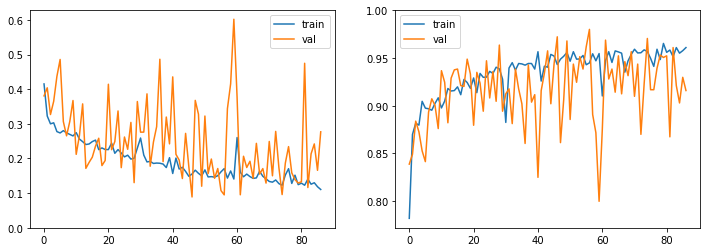

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6015 - accuracy: 0.6419 - precision: 0.8912 - recall: 0.5965 - f1: 0.7069 - specificity: 0.7777 - negative_predictive_value: 0.4014 - matthews_correlation_coefficient: 0.3305 - val_loss: 0.5485 - val_accuracy: 0.7042 - val_precision: 0.8362 - val_recall: 0.7044 - val_f1: 0.7602 - val_specificity: 0.6322 - val_negative_predictive_value: 0.4397 - val_matthews_correlation_coefficient: 0.3305

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33046, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_25-02_36_20.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5786 - accuracy: 0.6790 - precision: 0.8906 - recall: 0.6517 - f1: 0.7442 - specificity: 0.7572 - negative_predictive_value: 0.4303 - matthews_correlation_coefficient: 0.3614 - val_loss: 0.6295 - val_accuracy: 0.6756 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5398 - accuracy: 0.7065 - precision: 0.9052 - recall: 0.6786 - f1: 0.7690 - specificity: 0.7915 - negative_predictive_value: 0.4664 - matthews_correlation_coefficient: 0.4165 - val_loss: 0.5350 - val_accuracy: 0.7103 - val_precision: 0.8518 - val_recall: 0.6946 - val_f1: 0.7610 - val_specificity: 0.6825 - val_negative_predictive_value: 0.4547 - val_matthews_correlation_coefficient: 0.3658

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37703
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5357 - accuracy: 0.7059 - precision: 0.9036 - recall: 0.6800 - f1: 0.7714 - specificity: 0.7926 - negative_predictive_value: 0.4642 - matthews_correlation_coefficient: 0.4145 - val_loss: 0.6129 - val_accuracy: 0.6722 - val_precision: 0.8819 - val_recall: 0.6086 - val_f1: 0.7151 - val_specificity: 0.7815 - val_negative_predictive_value: 0.4193 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38403
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5200 - accuracy: 0.7119 - precision: 0.9086 - recall: 0.6862 - f1: 0.7758 - specificity: 0.7884 - negative_predictive_value: 0.4644 - matthews_correlation_coefficient: 0.4176 - val_loss: 0.5629 - val_accuracy: 0.7242 - val_precision: 0.8531 - val_recall: 0.7141 - val_f1: 0.7739 - val_specificity: 0.6808 - val_negative_predictive_value: 0.4665 - val_matthews_correlation_coefficient: 0.3811

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.38403
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5191 - accuracy: 0.7176 - precision: 0.9005 - recall: 0.6881 - f1: 0.7753 - specificity: 0.7919 - negative_predictive_value: 0.4709 - matthews_correlation_coefficient: 0.4266 - val_loss: 0.5484 - val_accuracy: 0.6956 - val_precision: 0.8678 - val_recall: 0.6537 - val_f1: 0.7415 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5064 - accuracy: 0.7197 - precision: 0.9033 - recall: 0.6868 - f1: 0.7759 - specificity: 0.8022 - negative_predictive_value: 0.4797 - matthews_correlation_coefficient: 0.4323 - val_loss: 0.5432 - val_accuracy: 0.7095 - val_precision: 0.8569 - val_recall: 0.6859 - val_f1: 0.7583 - val_specificity: 0.7072 - val_negative_predictive_value: 0.4530 - val_matthews_correlation_coefficient: 0.3751

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39264
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5155 - accuracy: 0.7026 - precision: 0.9185 - recall: 0.6623 - f1: 0.7635 - specificity: 0.8337 - negative_predictive_value: 0.4643 - matthews_correlation_coefficient: 0.4318 - val_loss: 0.5310 - val_accuracy: 0.7016 - val_precision: 0.8620 - val_recall: 0.6680 - val_f1: 0.7486 - val_specificity: 0.7241 - val_negative_predictive_value: 0.4431 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.40348
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4913 - accuracy: 0.7228 - precision: 0.9076 - recall: 0.6847 - f1: 0.7759 - specificity: 0.8206 - negative_predictive_value: 0.4829 - matthews_correlation_coefficient: 0.4422 - val_loss: 0.5570 - val_accuracy: 0.6904 - val_precision: 0.8702 - val_recall: 0.6450 - val_f1: 0.7361 - val_specificity: 0.7489 - val_negative_predictive_value: 0.4352 - val_matthews_correlation_coefficient: 0.3727

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40348
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4891 - accuracy: 0.7219 - precision: 0.9177 - recall: 0.6893 - f1: 0.7814 - specificity: 0.8205 - negative_predictive_value: 0.4791 - matthews_correlation_coefficient: 0.4474 - val_loss: 0.4930 - val_accuracy: 0.7476 - val_precision: 0.8330 - val_recall: 0.7734 - val_f1: 0.7995 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40532
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4818 - accuracy: 0.7328 - precision: 0.9196 - recall: 0.7028 - f1: 0.7916 - specificity: 0.8142 - negative_predictive_value: 0.4931 - matthews_correlation_coefficient: 0.4612 - val_loss: 0.5290 - val_accuracy: 0.7016 - val_precision: 0.8520 - val_recall: 0.6828 - val_f1: 0.7535 - val_specificity: 0.6872 - val_negative_predictive_value: 0.4403 - val_matthews_correlation_coefficient: 0.3549

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.40532
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4738 - accuracy: 0.7358 - precision: 0.9210 - recall: 0.7035 - f1: 0.7925 - specificity: 0.8221 - negative_predictive_value: 0.4899 - matthews_correlation_coefficient: 0.4630 - val_loss: 0.5246 - val_accuracy: 0.7199 - val_precision: 0.8592 - val_recall: 0.6999 - val_f1: 0.7685 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.40535
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4706 - accuracy: 0.7443 - precision: 0.9155 - recall: 0.7114 - f1: 0.7967 - specificity: 0.8097 - negative_predictive_value: 0.5034 - matthews_correlation_coefficient: 0.4666 - val_loss: 0.4917 - val_accuracy: 0.7225 - val_precision: 0.8550 - val_recall: 0.7101 - val_f1: 0.7722 - val_specificity: 0.6797 - val_negative_predictive_value: 0.4626 - val_matthews_correlation_coefficient: 0.3776

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.40535
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4833 - accuracy: 0.7345 - precision: 0.9178 - recall: 0.6968 - f1: 0.7858 - specificity: 0.8306 - negative_predictive_value: 0.4969 - matthews_correlation_coefficient: 0.4675 - val_loss: 0.5314 - val_accuracy: 0.7025 - val_precision: 0.8672 - val_recall: 0.6661 - val_f1: 0.7495 - val_spe

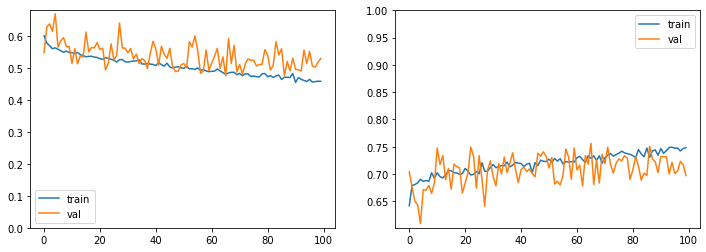

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4471 - accuracy: 0.7790 - precision: 0.9969 - recall: 0.7770 - f1: 0.8657 - specificity: 0.3287 - negative_predictive_value: 0.0625 - matthews_correlation_coefficient: 0.1174 - val_loss: 0.8742 - val_accuracy: 0.5707 - val_precision: 0.9730 - val_recall: 0.5493 - val_f1: 0.6972 - val_specificity: 0.3784 - val_negative_predictive_value: 0.0325 - val_matthews_correlation_coefficient: 0.0822

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.08224, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_25-02_51_14.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3675 - accuracy: 0.7937 - precision: 0.9979 - recall: 0.7938 - f1: 0.8796 - specificity: 0.3207 - negative_predictive_value: 0.0601 - matthews_correlation_coefficient: 0.1170 - val_loss: 0.2132 - val_accuracy: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.16032
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2697 - accuracy: 0.8304 - precision: 0.9995 - recall: 0.8295 - f1: 0.9055 - specificity: 0.3448 - negative_predictive_value: 0.0720 - matthews_correlation_coefficient: 0.1395 - val_loss: 0.3666 - val_accuracy: 0.8387 - val_precision: 1.0000 - val_recall: 0.8405 - val_f1: 0.9117 - val_specificity: 0.3784 - val_negative_predictive_value: 0.0742 - val_matthews_correlation_coefficient: 0.1511

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.16032
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2854 - accuracy: 0.8297 - precision: 0.9992 - recall: 0.8291 - f1: 0.9047 - specificity: 0.3724 - negative_predictive_value: 0.0817 - matthews_correlation_coefficient: 0.1542 - val_loss: 0.2706 - val_accuracy: 0.8612 - val_precision: 1.0000 - val_recall: 0.8629 - val_f1: 0.9252 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.16631
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2436 - accuracy: 0.8560 - precision: 0.9995 - recall: 0.8522 - f1: 0.9184 - specificity: 0.3828 - negative_predictive_value: 0.0928 - matthews_correlation_coefficient: 0.1714 - val_loss: 0.3035 - val_accuracy: 0.8500 - val_precision: 1.0000 - val_recall: 0.8516 - val_f1: 0.9183 - val_specificity: 0.3784 - val_negative_predictive_value: 0.0786 - val_matthews_correlation_coefficient: 0.1558

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.16631
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2304 - accuracy: 0.8523 - precision: 0.9995 - recall: 0.8517 - f1: 0.9185 - specificity: 0.3414 - negative_predictive_value: 0.0911 - matthews_correlation_coefficient: 0.1597 - val_loss: 0.2447 - val_accuracy: 0.8725 - val_precision: 0.9981 - val_recall: 0.8756 - val_f1: 0.9317 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2281 - accuracy: 0.8508 - precision: 0.9997 - recall: 0.8498 - f1: 0.9175 - specificity: 0.3621 - negative_predictive_value: 0.0842 - matthews_correlation_coefficient: 0.1584 - val_loss: 0.1614 - val_accuracy: 0.8907 - val_precision: 0.9972 - val_recall: 0.8946 - val_f1: 0.9421 - val_specificity: 0.3243 - val_negative_predictive_value: 0.0910 - val_matthews_correlation_coefficient: 0.1544

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.18514
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2583 - accuracy: 0.8377 - precision: 0.9992 - recall: 0.8374 - f1: 0.9097 - specificity: 0.3862 - negative_predictive_value: 0.0862 - matthews_correlation_coefficient: 0.1640 - val_loss: 0.2908 - val_accuracy: 0.8647 - val_precision: 0.9991 - val_recall: 0.8672 - val_f1: 0.9273 - val_specificity: 0.3514 - val_negative_predictive_value: 0.0827 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2303 - accuracy: 0.8536 - precision: 0.9995 - recall: 0.8497 - f1: 0.9164 - specificity: 0.3448 - negative_predictive_value: 0.0874 - matthews_correlation_coefficient: 0.1576 - val_loss: 0.3449 - val_accuracy: 0.8378 - val_precision: 1.0000 - val_recall: 0.8395 - val_f1: 0.9107 - val_specificity: 0.3784 - val_negative_predictive_value: 0.0735 - val_matthews_correlation_coefficient: 0.1498

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.18514
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1826 - accuracy: 0.8818 - precision: 1.0000 - recall: 0.8777 - f1: 0.9337 - specificity: 0.3517 - negative_predictive_value: 0.1078 - matthews_correlation_coefficient: 0.1809 - val_loss: 0.3102 - val_accuracy: 0.8812 - val_precision: 1.0000 - val_recall: 0.8825 - val_f1: 0.9364 - val_specificity: 0.3784 - val_negative_predictive_value: 0.0965 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.19358
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1981 - accuracy: 0.8824 - precision: 0.9997 - recall: 0.8816 - f1: 0.9361 - specificity: 0.3379 - negative_predictive_value: 0.0944 - matthews_correlation_coefficient: 0.1639 - val_loss: 0.2608 - val_accuracy: 0.8734 - val_precision: 1.0000 - val_recall: 0.8747 - val_f1: 0.9319 - val_specificity: 0.3784 - val_negative_predictive_value: 0.0914 - val_matthews_correlation_coefficient: 0.1700

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.19358
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1844 - accuracy: 0.8922 - precision: 0.9998 - recall: 0.8918 - f1: 0.9419 - specificity: 0.3690 - negative_predictive_value: 0.1198 - matthews_correlation_coefficient: 0.1943 - val_loss: 0.3305 - val_accuracy: 0.8491 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1: 0.9175 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.19358
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2279 - accuracy: 0.8577 - precision: 0.9998 - recall: 0.8537 - f1: 0.9194 - specificity: 0.3241 - negative_predictive_value: 0.0879 - matthews_correlation_coefficient: 0.1524 - val_loss: 0.2796 - val_accuracy: 0.8456 - val_precision: 1.0000 - val_recall: 0.8472 - val_f1: 0.9152 - val_specificity: 0.3784 - val_negative_predictive_value: 0.0753 - val_matthews_correlation_coefficient: 0.1507

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.19358
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2045 - accuracy: 0.8703 - precision: 0.9995 - recall: 0.8699 - f1: 0.9293 - specificity: 0.3494 - negative_predictive_value: 0.0999 - matthews_correlation_coefficient: 0.1706 - val_loss: 0.2597 - val_accuracy: 0.8829 - val_precision: 1.0000 - val_recall: 0.8841 - val_f1: 0.9375 - val_spe

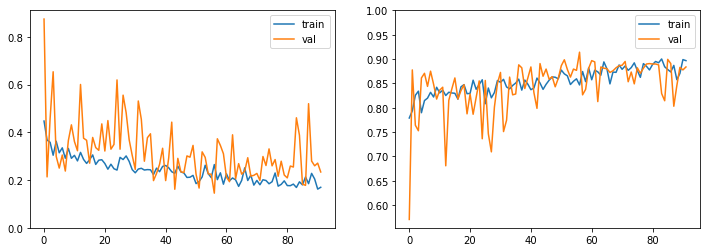

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_24-22_09_13.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_24-22_24_05.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_24-22_38_47.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_24-22_53_26.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_24-23_08_03.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_24-23_17_08.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_24-23_24_52.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_24-23_39_37.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_24-23_54_21.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_25-00_09_05.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_25-00_19_21.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_25-00_34_13.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_25-00_49_04.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images\AR_FDB_m-013-17.png


<>:5: DeprecationWarning: invalid escape sequence \A
<>:5: DeprecationWarning: invalid escape sequence \A
<>:5: DeprecationWarning: invalid escape sequence \A
<ipython-input-36-ab7dd1e2830b>:5: DeprecationWarning: invalid escape sequence \A
  list_files = ['../data/pybossa/images\AR_FDB_m-013-17.png']


[array([[0.99995744]], dtype=float32),
 array([[0.5287483]], dtype=float32),
 array([[0.9711232]], dtype=float32),
 array([[0.9913811]], dtype=float32),
 array([[0.94905436]], dtype=float32),
 array([[0.9918451]], dtype=float32),
 array([[0.7662018]], dtype=float32),
 array([[0.43529952]], dtype=float32),
 array([[0.66160756]], dtype=float32),
 array([[0.9092016]], dtype=float32),
 array([[0.992109]], dtype=float32),
 array([[0.73497826]], dtype=float32),
 array([[0.9999784]], dtype=float32),
 array([[0.9834537]], dtype=float32),
 array([[0.9500989]], dtype=float32),
 array([[0.31495327]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.77899444]], dtype=float32),
 array([[0.9999981]], dtype=float32),
 array([[0.999801]], dtype=float32),
 array([[0.56362724]], dtype=float32),
 array([[1.]], dtype=float32)]